# GPU-Accelerated Bike Sharing Analysis

This notebook uses **NVIDIA RAPIDS** for GPU acceleration when available, providing significant speedup over CPU-only processing.

## Performance Comparison:
- **GPU Mode (RAPIDS)**: 10-100x faster for large datasets
- **CPU Mode (fallback)**: Automatic fallback if GPU not available

## Requirements for GPU Mode:
- NVIDIA GPU with CUDA support (GTX 1060 or better recommended)
- CUDA Toolkit 11.x
- RAPIDS libraries (cuDF, CuPy)

The notebook will automatically detect GPU availability and use the best acceleration method.

In [2]:
# Install required libraries
!pip install -q pandas numpy requests matplotlib seaborn mlxtend scipy scikit-learn

# GPU acceleration note: RAPIDS (cuDF) only works on Linux
# On Windows, we'll use CuPy for GPU-accelerated array operations
import sys
if sys.platform == 'win32':
    print("📌 Running on Windows - installing CuPy for GPU acceleration")
    print("   (Note: Full RAPIDS support requires Linux/WSL2)")
    # Try to install CuPy for Windows (CUDA 11.x)
    !pip install -q cupy-cuda11x 2>nul || echo "⚠ CuPy installation skipped - will use CPU"
else:
    print("📌 Running on Linux - attempting full RAPIDS installation")
    # On Linux, try to install full RAPIDS stack
    !pip install -q --extra-index-url https://pypi.nvidia.com/ cudf-cu11 cuml-cu11 2>/dev/null || echo "⚠ RAPIDS installation skipped - will use CPU"

print("✓ Library installation complete")

📌 Running on Windows - installing CuPy for GPU acceleration
   (Note: Full RAPIDS support requires Linux/WSL2)
✓ Library installation complete


In [3]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

# GPU acceleration detection with platform-specific support
GPU_AVAILABLE = False
GPU_TYPE = "None"

# Try CuPy first (works on Windows + Linux)
try:
    import cupy as cp
    # Test if GPU is actually available
    cp.cuda.Device(0).compute_capability
    GPU_AVAILABLE = True
    GPU_TYPE = "CuPy"
    print(f"✓ GPU acceleration enabled: CuPy")
    print(f"✓ GPU: {cp.cuda.runtime.getDeviceProperties(0)['name'].decode()}")
    print(f"✓ GPU Memory: {cp.cuda.Device().mem_info[1] / 1e9:.2f} GB total")
    print(f"✓ CUDA Version: {cp.cuda.runtime.runtimeGetVersion()}")
except Exception as e:
    print(f"⚠ CuPy not available: {type(e).__name__}")

# Try RAPIDS cuDF (Linux only, more powerful)
if sys.platform != 'win32' and not GPU_AVAILABLE:
    try:
        import cudf
        from cuml.preprocessing import StandardScaler as cuStandardScaler
        GPU_AVAILABLE = True
        GPU_TYPE = "RAPIDS"
        print("✓ GPU acceleration enabled: RAPIDS cuDF + cuML")
        print(f"✓ Full RAPIDS stack available")
    except ImportError:
        print("⚠ RAPIDS not available (Linux-only feature)")

if not GPU_AVAILABLE:
    print("ℹ Using CPU mode (standard pandas/numpy)")
    print("  For GPU support:")
    if sys.platform == 'win32':
        print("  - Windows: Install CuPy with 'pip install cupy-cuda11x'")
        print("  - Or use WSL2 + Linux for full RAPIDS support")
    else:
        print("  - Linux: pip install --extra-index-url https://pypi.nvidia.com/ cudf-cu11")

print(f"\nMode: {GPU_TYPE if GPU_AVAILABLE else 'CPU'}")

c:\Users\rishi\miniforge3\envs\ML\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


✓ GPU acceleration enabled: CuPy
✓ GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
✓ GPU Memory: 6.44 GB total
✓ CUDA Version: 11080

Mode: CuPy


In [4]:
import os

# Configuration: URL to download CSV from
CSV_URL = "https://pub-c5da5968baf1476f998733ecc980092f.r2.dev/Trips_2018.csv"
CSV_FILE = "Trips_2018.csv"

# Download CSV if not present locally
if not os.path.exists(CSV_FILE):
    print(f"Downloading {CSV_FILE} from {CSV_URL}...")
    import requests
    
    response = requests.get(CSV_URL, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    print(f"File size: {total_size / 1024 / 1024:.2f} MB")
    
    with open(CSV_FILE, 'wb') as f:
        downloaded = 0
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
                downloaded += len(chunk)
                if total_size:
                    progress = (downloaded / total_size) * 100
                    print(f"Progress: {progress:.1f}%", end='\r')
    
    print(f"\n✓ Download complete!")
else:
    print(f"✓ {CSV_FILE} already exists locally")

# Load the CSV
df = pd.read_csv(CSV_FILE)

#Remove unwanted index column if it exists
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

#Convert start and stop times to proper datetime format
df["starttime"] = pd.to_datetime(df["starttime"], errors="coerce")
df["stoptime"]  = pd.to_datetime(df.get("stoptime"), errors="coerce")


#Create a new column 'start_hour' — the trip's start time rounded down to the hour (used later to join with hourly weather data)
df["start_hour"] = df["starttime"].dt.floor("h")

#Compute trip duration in minutes
df["trip_duration_min"] = (
    df["tripduration"]/60.0
    if "tripduration" in df.columns
    else (df["stoptime"] - df["starttime"]).dt.total_seconds()/60
)

#Find a representative latitude and longitude for weather data Using median coordinates ensures one central location (e.g., NYC center)
LAT, LON = df["start_station_latitude"].median(), df["start_station_longitude"].median()

#Find the overall date range of the dataset for API query
START = df["start_hour"].min().date().isoformat()
END   = df["start_hour"].max().date().isoformat()

#Print a quick summary
print(f"Trips: {len(df)}  |  Date span: {START} → {END}")
df.head()


✓ Trips_2018.csv already exists locally
Trips: 17548339  |  Date span: 2018-01-01 → 2018-12-31


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour,trip_duration_min
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,2018-01-01 13:00:00,16.166667
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,2018-01-01 15:00:00,12.050000
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,2018-01-01 15:00:00,8.266667
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,2018-01-01 15:00:00,5.100000
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,2018-01-01 18:00:00,5.100000


## Data Cleaning: Remove Outliers and Invalid Data

In [5]:
print("=" * 70)
print("DATA CLEANING: Removing Outliers and Invalid Records")
print("=" * 70)

initial_count = len(df)
print(f"\nInitial dataset: {initial_count:,} trips")

# 1. AGE/BIRTH YEAR OUTLIERS
print("\n1️⃣ BIRTH YEAR / AGE CLEANING:")
print(f"   Before: Birth year range: {df['birth_year'].min():.0f} - {df['birth_year'].max():.0f}")

# Calculate age (in 2018)
df['age_temp'] = 2018 - df['birth_year']

# Define reasonable age range for bike riders (13-90 years old)
MIN_AGE = 7
MAX_AGE = 90
MIN_BIRTH_YEAR = 2018 - MAX_AGE  
MAX_BIRTH_YEAR = 2018 - MIN_AGE 

# Filter out invalid ages
age_invalid = df[(df['birth_year'] < MIN_BIRTH_YEAR) | (df['birth_year'] > MAX_BIRTH_YEAR) | (df['birth_year'].isna())]
print(f"   Found {len(age_invalid):,} trips with invalid ages:")
print(f"     - Ages < {MIN_AGE} or > {MAX_AGE} years")
print(f"     - Birth years < {MIN_BIRTH_YEAR} or > {MAX_BIRTH_YEAR}")
print(f"     - Missing birth year values")

df = df[(df['birth_year'] >= MIN_BIRTH_YEAR) & (df['birth_year'] <= MAX_BIRTH_YEAR)]
print(f"   After: Birth year range: {df['birth_year'].min():.0f} - {df['birth_year'].max():.0f}")
print(f"   Removed: {len(age_invalid):,} trips ({len(age_invalid)/initial_count*100:.2f}%)")

# 2. TRIP DURATION OUTLIERS
print("\n2️⃣ TRIP DURATION CLEANING:")
print(f"   Before: Duration range: {df['tripduration'].min():.0f}s - {df['tripduration'].max():.0f}s")
print(f"   Before: Duration range: {df['tripduration'].min()/60:.1f}min - {df['tripduration'].max()/3600:.1f}hrs")

# Remove trips that are too short (< 60 seconds, likely errors) or too long (> 24 hours, likely stolen/lost bikes)
MIN_DURATION = 60  # 1 minute
MAX_DURATION = 24 * 3600  # 24 hours

duration_invalid = df[(df['tripduration'] < MIN_DURATION) | (df['tripduration'] > MAX_DURATION)]
print(f"   Found {len(duration_invalid):,} trips with invalid durations:")
print(f"     - Durations < {MIN_DURATION}s (1 min)")
print(f"     - Durations > {MAX_DURATION}s (24 hours)")

df = df[(df['tripduration'] >= MIN_DURATION) & (df['tripduration'] <= MAX_DURATION)]
print(f"   After: Duration range: {df['tripduration'].min():.0f}s - {df['tripduration'].max():.0f}s")
print(f"   After: Duration range: {df['tripduration'].min()/60:.1f}min - {df['tripduration'].max()/3600:.1f}hrs")
print(f"   Removed: {len(duration_invalid):,} trips ({len(duration_invalid)/initial_count*100:.2f}%)")

# 3. MISSING CRITICAL VALUES
print("\n3️⃣ MISSING CRITICAL VALUES:")
missing_before = df[['start_station_id', 'end_station_id', 'usertype']].isna().any(axis=1).sum()
print(f"   Found {missing_before:,} trips with missing station IDs or usertype")

df = df.dropna(subset=['start_station_id', 'end_station_id', 'usertype'])
print(f"   Removed: {missing_before:,} trips")

# 4. SUMMARY
print("\n" + "=" * 70)
print("CLEANING SUMMARY:")
print("=" * 70)
final_count = len(df)
total_removed = initial_count - final_count
print(f"Initial trips:    {initial_count:,}")
print(f"Final trips:      {final_count:,}")
print(f"Total removed:    {total_removed:,} ({total_removed/initial_count*100:.2f}%)")
print(f"Data quality:     {final_count/initial_count*100:.2f}% retained")

# Drop temporary column
df = df.drop(columns=['age_temp'])

print("\n✅ Data cleaning complete!")
df.head()

DATA CLEANING: Removing Outliers and Invalid Records

Initial dataset: 17,548,339 trips

1️⃣ BIRTH YEAR / AGE CLEANING:
   Before: Birth year range: 1885 - 2002
   Found 13,452 trips with invalid ages:
     - Ages < 7 or > 90 years
     - Birth years < 1928 or > 2011
     - Missing birth year values
   After: Birth year range: 1928 - 2002
   Removed: 13,452 trips (0.08%)

2️⃣ TRIP DURATION CLEANING:
   Before: Duration range: 61s - 19510049s
   Before: Duration range: 1.0min - 5419.5hrs
   Found 4,519 trips with invalid durations:
     - Durations < 60s (1 min)
     - Durations > 86400s (24 hours)
   After: Duration range: 61s - 86385s
   After: Duration range: 1.0min - 24.0hrs
   Removed: 4,519 trips (0.03%)

3️⃣ MISSING CRITICAL VALUES:
   Found 2,485 trips with missing station IDs or usertype
   Removed: 2,485 trips

CLEANING SUMMARY:
Initial trips:    17,548,339
Final trips:      17,527,883
Total removed:    20,456 (0.12%)
Data quality:     99.88% retained

✅ Data cleaning complete

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour,trip_duration_min
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,2018-01-01 13:00:00,16.166667
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,2018-01-01 15:00:00,12.050000
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,2018-01-01 15:00:00,8.266667
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,2018-01-01 15:00:00,5.100000
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,2018-01-01 18:00:00,5.100000


In [6]:
# --- Weather by small spatial grid (fast, robust, with fallback) ---
stations = df[["start_station_id", "start_station_latitude", "start_station_longitude"]].drop_duplicates()

# 1) Build a small grid (≈2–3 km) to reduce API calls
GRID = 0.03  # ↑ 0.05 fewer calls, ↓ 0.02 more detail

stations = stations.copy()
stations["lat_bin"] = (stations["start_station_latitude"]  / GRID).round().astype(int)
stations["lon_bin"] = (stations["start_station_longitude"] / GRID).round().astype(int)
stations["cell_id"] = stations["lat_bin"].astype(str) + "_" + stations["lon_bin"].astype(str)

cells = (stations.groupby("cell_id", as_index=False)
         .agg(lat=("start_station_latitude", "median"),
              lon=("start_station_longitude", "median")))

print(f"Unique grid cells to fetch: {len(cells)}")


# 2) Helper: polite, retrying fetch per cell
def fetch_cell(lat, lon, start_date, end_date, retries=5, pause=1.5):
    url = "https://archive-api.open-meteo.com/v1/era5"
    hourly_vars = [
        "temperature_2m","apparent_temperature","rain","snowfall",
        "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
    ]
    params = {
        "latitude": float(lat), "longitude": float(lon),
        "start_date": start_date, "end_date": end_date,
        "timezone": "America/New_York",
        "hourly": ",".join(hourly_vars)  # more robust than list for some clients
    }
    last_err = None
    for a in range(retries):
        try:
            resp = requests.get(url, params=params, timeout=40)
            if resp.ok:
                js = resp.json()
                if "hourly" in js:
                    wx = pd.DataFrame(js["hourly"])
                    wx["start_hour"] = pd.to_datetime(wx["time"])
                    wx = wx.drop(columns=["time"])
                    # downcast floats to save memory
                    for c in wx.columns:
                        if c != "start_hour" and pd.api.types.is_float_dtype(wx[c]):
                            wx[c] = pd.to_numeric(wx[c], downcast="float")
                    return wx
                else:
                    last_err = f"no 'hourly' in response (keys={list(js.keys())})"
            else:
                last_err = f"HTTP {resp.status_code}: {resp.text[:160]}"
        except Exception as e:
            last_err = str(e)
        time.sleep(pause * (a + 1))  # gentle backoff
    # Uncomment for debugging:
    # print(f"Fetch failed for ({lat:.4f},{lon:.4f}): {last_err}")
    return None


# 3) Fetch once per cell
cell_weather, failed_cells = [], []
for _, r in cells.iterrows():
    wx_cell = fetch_cell(r["lat"], r["lon"], START, END)
    if wx_cell is None:
        failed_cells.append(r["cell_id"])
        continue
    wx_cell["cell_id"] = r["cell_id"]
    cell_weather.append(wx_cell)
    time.sleep(0.2)  # pacing

# --- Fallback if everything failed: use single (city-median) point ---
if not cell_weather:
    print("⚠️ All grid cells failed. Falling back to city-median weather…")
    lat0 = float(df["start_station_latitude"].median())
    lon0 = float(df["start_station_longitude"].median())
    wx_city = fetch_cell(lat0, lon0, START, END)
    if wx_city is None:
        raise RuntimeError(
            f"No weather fetched even for city median. Check network/date range. START={START}, END={END}"
        )
    wx_city["cell_id"] = "city_median"
    wx_cells = wx_city.copy()
    stations2 = stations.copy()
    stations2["use_cell"] = "city_median"
else:
    wx_cells = pd.concat(cell_weather, ignore_index=True)
    print(f"Weather rows (cells): {len(wx_cells)} | cells covered: {wx_cells['cell_id'].nunique()}")

    # 4) If some cells failed, borrow weather from nearest fetched cell
    if failed_cells:
        print("Filling missing cells from nearest fetched cell…")

        have = cells[cells["cell_id"].isin(wx_cells["cell_id"].unique())].copy()
        need = cells[cells["cell_id"].isin(failed_cells)].copy()

        def haversine(lat1, lon1, lat2, lon2):
            R = 6371.0
            lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
            dlat, dlon = lat2 - lat1, lon2 - lon1
            a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
            return 2 * R * np.arcsin(np.sqrt(a))

        alias_rows = []
        H_lat = have["lat"].to_numpy()
        H_lon = have["lon"].to_numpy()
        for _, r in need.iterrows():
            d = haversine(r["lat"], r["lon"], H_lat, H_lon)
            nearest = have.iloc[d.argmin()]["cell_id"]
            alias_rows.append((r["cell_id"], nearest))
        alias = pd.DataFrame(alias_rows, columns=["cell_id", "use_cell"])
    else:
        alias = pd.DataFrame(columns=["cell_id", "use_cell"])

    # Stations use their own cell if fetched, otherwise the nearest fetched cell
    stations2 = stations.merge(alias, on="cell_id", how="left")
    stations2["use_cell"] = stations2["use_cell"].fillna(stations2["cell_id"])

# 5) Expand cell weather back to stations
wx = (stations2[["start_station_id", "use_cell"]]
      .rename(columns={"use_cell": "cell_id"})
      .merge(wx_cells, on="cell_id", how="left"))

print("Total weather rows (expanded to stations):", len(wx))


Unique grid cells to fetch: 23
Weather rows (cells): 201480 | cells covered: 23
Total weather rows (expanded to stations): 7174440


In [7]:
# === Merge trips with hourly weather ===

is_station_level = "start_station_id" in wx.columns
key_cols = ["start_hour"] + (["start_station_id"] if is_station_level else [])

print("Merging on:", key_cols)

# keep only weather fields we actually need (saves memory) if present
wanted_wx = [
    "start_hour", "start_station_id",
    "temperature_2m","apparent_temperature","rain","snowfall",
    "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
]
wx_keyed = wx[[c for c in wanted_wx if c in wx.columns]].drop_duplicates(subset=key_cols)

dfm = df.merge(
    wx_keyed,
    on=key_cols,
    how="left",          # keep all trips/columns from df
    validate="m:1"       # many trips to one weather row
)

# merge quality
miss_pct = dfm["temperature_2m"].isna().mean() * 100
print(f"Merge complete | rows={len(dfm):,} | weather coverage={100 - miss_pct:.1f}%")

dfm.head()

Merging on: ['start_hour', 'start_station_id']
Merge complete | rows=17,527,883 | weather coverage=100.0%


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,start_hour,trip_duration_min,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,relative_humidity_2m,cloud_cover,visibility
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,...,2018-01-01 13:00:00,16.166667,-8.1,-14.9,0.0,0.0,20.400000,30,0,None
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,...,2018-01-01 15:00:00,12.050000,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,...,2018-01-01 15:00:00,8.266667,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,...,2018-01-01 15:00:00,5.100000,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,...,2018-01-01 18:00:00,5.100000,-10.0,-15.0,0.0,0.0,7.400000,39,23,None


In [8]:
# === Feature engineering: concise, robust, memory-friendly ===

need = ["temperature_2m","rain","snowfall","wind_speed_10m","cloud_cover","visibility"]
for c in need:
    if c not in dfm.columns:
        dfm[c] = np.nan
dfm[need] = dfm[need].apply(pd.to_numeric, errors="coerce")

# 1) Temperature (°C) + readable buckets
dfm["temp_celsius"] = dfm["temperature_2m"]
dfm["temp_category"] = pd.cut(
    dfm["temp_celsius"],
    bins=[-99, 0, 10, 20, 25, 30, 99],
    labels=["freezing","cold","cool","comfortable","warm","hot"]
)

# 2) Dryness (1 dry, 0 wet)
rain  = dfm["rain"].fillna(0)
snow  = dfm["snowfall"].fillna(0)
dfm["is_dry"] = ((rain + snow) == 0).astype("int8")

# 3) Wind, sky, visibility
dfm["wind_kmh"] = dfm["wind_speed_10m"] * 3.6
dfm["sky_condition"] = pd.cut(
    dfm["cloud_cover"],
    bins=[-1, 25, 50, 75, 100.1],
    labels=["clear","partly_cloudy","cloudy","overcast"]
)
dfm["visibility_km"] = dfm["visibility"] / 1000.0

# 4) Cycling Score (0–100): Weights proportional to empirical correlation coefficients
# temp r=0.443, is_dry r=0.128 → normalized to percentages: 69/20/7/4
dfm["cycling_score"] = (
    np.exp(-((dfm["temp_celsius"] - 20) / 10) ** 2) * 69           # temperature comfort peak ~20°C (69%)
    + dfm["is_dry"] * 20                                           # dry bonus (20%)
    + (dfm["wind_kmh"] < 20).astype("int8") * 7                    # calm wind (7%)
    + (dfm["visibility_km"] > 5).astype("int8") * 4                # clear view (4%)
).clip(0, 100)

# 5) Compact memory for categories
dfm["temp_category"] = dfm["temp_category"].astype("category")
dfm["sky_condition"]  = dfm["sky_condition"].astype("category")

print(f"Weather features added | shape={dfm.shape} | new cols: "
      f"['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']")
dfm.head()


Weather features added | shape=(17527883, 30) | new cols: ['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,relative_humidity_2m,cloud_cover,visibility,temp_celsius,temp_category,is_dry,wind_kmh,sky_condition,visibility_km,cycling_score
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,...,30,0,NaN,-8.1,freezing,1,73.439995,clear,NaN,20.025681
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,20.049688
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,20.049688
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,20.049688
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,...,39,23,NaN,-10.0,freezing,1,26.639999,clear,NaN,20.008514


In [9]:
print("\n" + "="*70)
print("PREPARING FULL DATASET FOR ANALYSIS")
print("="*70)

# Add temporal columns needed for analysis
dfm['day_of_week'] = dfm['starttime'].dt.dayofweek
dfm['is_weekend'] = (dfm['day_of_week'] >= 5).astype(int)
dfm['hour'] = dfm['start_hour'].dt.hour
dfm['month'] = dfm['starttime'].dt.month

print(f"Dataset ready: {len(dfm):,} trips with weather and temporal features")


PREPARING FULL DATASET FOR ANALYSIS
Dataset ready: 17,527,883 trips with weather and temporal features


In [10]:
print("\n" + "="*70)
print(f"PROCESSING FULL DATASET - {GPU_TYPE if GPU_AVAILABLE else 'CPU'} MODE")
print("="*70)

import os

if GPU_AVAILABLE and GPU_TYPE == "CuPy":
    # Windows-compatible GPU acceleration using CuPy
    print(f"✓ Using CuPy GPU acceleration (Windows-compatible)")
    
    # GPU-accelerated batch processing with CuPy
    def process_batch_cupy(batch_data):
        """Process a batch on GPU using CuPy and return transactions, routes, and profiles"""
        batch, batch_num = batch_data
        
        # APRIORI: Create transactions (GPU-vectorized with CuPy)
        batch_clean = batch.dropna(subset=['start_station_id', 'end_station_id'])
        
        batch_transactions = []
        route_counts = {}
        
        if len(batch_clean) > 0:
            # Use CuPy arrays for GPU processing
            starts = cp.asarray(batch_clean['start_station_id'].astype('int64').values)
            ends = cp.asarray(batch_clean['end_station_id'].astype('int64').values)
            hours = cp.asarray(batch_clean['hour'].values)
            scores = cp.asarray(batch_clean['cycling_score'].values)
            
            # Transfer to CPU for transaction building (minimal data)
            starts_cpu = cp.asnumpy(starts)
            ends_cpu = cp.asnumpy(ends)
            hours_cpu = cp.asnumpy(hours)
            scores_cpu = cp.asnumpy(scores)
            
            for i in range(len(starts_cpu)):
                start, end = int(starts_cpu[i]), int(ends_cpu[i])
                
                transaction = [
                    f"route_{start}_to_{end}",
                    f"start_{start}",
                    f"end_{end}",
                ]
                
                # Time period
                hour = hours_cpu[i]
                if 7 <= hour <= 9:
                    transaction.append("morning_commute")
                elif 17 <= hour <= 19:
                    transaction.append("evening_commute")
                else:
                    transaction.append("non_commute")
                
                # Weather condition
                if scores_cpu[i] >= 70:
                    transaction.append("good_weather")
                else:
                    transaction.append("poor_weather")
                
                batch_transactions.append(transaction)
                
                # Count routes
                route_key = f"{start}_to_{end}"
                route_counts[route_key] = route_counts.get(route_key, 0) + 1
        
        # CLUSTERING: Create user profiles (pandas groupby)
        batch_profiles = batch.groupby(['birth_year', 'gender'], observed=True).agg({
            'tripduration': ['mean', 'std', 'count'],
            'trip_duration_min': ['mean', 'median'],
            'start_station_id': 'nunique',
            'end_station_id': 'nunique',
            'hour': ['mean', 'std'],
            'is_weekend': 'mean',
            'day_of_week': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean(),
            'cycling_score': ['mean', 'std'],
            'temp_celsius': 'mean',
            'is_dry': 'mean',
            'usertype': lambda x: 1 if len(x) > 0 and x.mode()[0] == 'Subscriber' else 0
        }).reset_index()
        
        return batch_transactions, route_counts, batch_profiles
    
    # Process data in GPU-optimized batches
    BATCH_SIZE = 1000000  # Larger batches on GPU
    batch_indices = list(range(0, len(dfm), BATCH_SIZE))
    batches = [(dfm.iloc[i:min(i + BATCH_SIZE, len(dfm))], idx // BATCH_SIZE + 1) 
               for idx, i in enumerate(batch_indices)]
    
    print(f"Processing {len(dfm):,} trips in {len(batches)} GPU batches")
    
    # Process batches sequentially on GPU (GPU is already parallel)
    results = []
    for i, batch in enumerate(batches, 1):
        result = process_batch_cupy(batch)
        results.append(result)
        if i % 2 == 0 or i == len(batches):
            print(f"  Completed {i}/{len(batches)} GPU batches")
    
else:
    # CPU fallback with multiprocessing
    from multiprocessing import Pool, cpu_count
    from functools import partial
    
    NUM_WORKERS = max(1, cpu_count() - 1)
    BATCH_SIZE = 500000
    
    print(f"Using {NUM_WORKERS} CPU cores for parallel processing")
    print(f"Processing {len(dfm):,} trips in batches of {BATCH_SIZE:,}")
    
    def process_batch_cpu(batch_data):
        """Process a batch of trips and return transactions, routes, and profiles"""
        batch, batch_num = batch_data
        
        # APRIORI: Create transactions (vectorized approach)
        batch_clean = batch.dropna(subset=['start_station_id', 'end_station_id']).copy()
        
        batch_transactions = []
        route_counts = {}
        
        if len(batch_clean) > 0:
            # Convert to numpy for faster processing
            starts = batch_clean['start_station_id'].astype(int).values
            ends = batch_clean['end_station_id'].astype(int).values
            hours = batch_clean['hour'].values
            scores = batch_clean['cycling_score'].values
            
            for i in range(len(starts)):
                start, end = starts[i], ends[i]
                
                transaction = [
                    f"route_{start}_to_{end}",
                    f"start_{start}",
                    f"end_{end}",
                ]
                
                # Time period
                hour = hours[i]
                if 7 <= hour <= 9:
                    transaction.append("morning_commute")
                elif 17 <= hour <= 19:
                    transaction.append("evening_commute")
                else:
                    transaction.append("non_commute")
                
                # Weather condition
                if scores[i] >= 70:
                    transaction.append("good_weather")
                else:
                    transaction.append("poor_weather")
                
                batch_transactions.append(transaction)
                
                # Count routes
                route_key = f"{start}_to_{end}"
                route_counts[route_key] = route_counts.get(route_key, 0) + 1
        
        # CLUSTERING: Create user profiles
        batch_profiles = batch.groupby(['birth_year', 'gender'], observed=True).agg({
            'tripduration': ['mean', 'std', 'count'],
            'trip_duration_min': ['mean', 'median'],
            'start_station_id': 'nunique',
            'end_station_id': 'nunique',
            'hour': ['mean', 'std'],
            'is_weekend': 'mean',
            'day_of_week': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean(),
            'cycling_score': ['mean', 'std'],
            'temp_celsius': 'mean',
            'is_dry': 'mean',
            'usertype': lambda x: 1 if len(x) > 0 and x.mode()[0] == 'Subscriber' else 0
        }).reset_index()
        
        return batch_transactions, route_counts, batch_profiles
    
    # Split data into batches
    batch_indices = list(range(0, len(dfm), BATCH_SIZE))
    batches = [(dfm.iloc[i:min(i + BATCH_SIZE, len(dfm))], idx // BATCH_SIZE + 1) 
               for idx, i in enumerate(batch_indices)]
    
    print(f"Created {len(batches)} batches for parallel processing")
    
    # Process batches in parallel
    if NUM_WORKERS > 1:
        with Pool(processes=NUM_WORKERS) as pool:
            results = []
            for i, result in enumerate(pool.imap(process_batch_cpu, batches), 1):
                results.append(result)
                if i % 5 == 0:
                    print(f"  Completed {i}/{len(batches)} batches")
    else:
        results = [process_batch_cpu(batch) for batch in batches]

print("Merging results from all batches...")

# Merge results from all batches
all_transactions = []
route_counter = {}
user_profiles_list = []

for batch_trans, batch_routes, batch_profiles in results:
    all_transactions.extend(batch_trans)
    
    # Merge route counts
    for route, count in batch_routes.items():
        route_counter[route] = route_counter.get(route, 0) + count
    
    user_profiles_list.append(batch_profiles)

print(f"\nProcessing complete:")
print(f"  Transactions: {len(all_transactions):,}")
print(f"  Unique routes: {len(route_counter):,}")
print(f"  Acceleration: {GPU_TYPE if GPU_AVAILABLE else 'CPU multiprocessing'}")


PROCESSING FULL DATASET - CuPy MODE
✓ Using CuPy GPU acceleration (Windows-compatible)
Processing 17,527,883 trips in 18 GPU batches
  Completed 2/18 GPU batches
  Completed 4/18 GPU batches
  Completed 6/18 GPU batches
  Completed 8/18 GPU batches
  Completed 10/18 GPU batches
  Completed 12/18 GPU batches
  Completed 14/18 GPU batches
  Completed 16/18 GPU batches
  Completed 18/18 GPU batches
Merging results from all batches...

Processing complete:
  Transactions: 17,527,883
  Unique routes: 347,178
  Acceleration: CuPy


#  Apriori Analysis


FULL PIPELINE: PATTERN MINING + VISUALIZATIONS

Mining results missing: ['simplified_trans', 'frequent_itemsets', 'rules', 'commute_patterns', 'weather_patterns']
→ Running mining step now...


Top 10 Most Frequent Routes (Full Dataset):
   1. 2006 → 2006: 7,849 trips (0.04%)
   2. 432 → 3263: 7,249 trips (0.04%)
   3. 281 → 281: 6,340 trips (0.04%)
   4. 2006 → 3282: 6,214 trips (0.04%)
   5. 460 → 3093: 5,455 trips (0.03%)
   6. 3093 → 460: 5,131 trips (0.03%)
   7. 435 → 509: 4,995 trips (0.03%)
   8. 519 → 492: 4,662 trips (0.03%)
   9. 519 → 498: 4,465 trips (0.03%)
  10. 387 → 387: 4,463 trips (0.03%)
Creating simplified transactions from ALL trips...
Transactions for mining: 17,527,883 / 17,527,883
Sparse encoding transactions...


C:\Users\rishi\AppData\Local\Temp\ipykernel_20680\370891604.py:100: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary_sparse, columns=te.columns_)


Encoded matrix shape: (17527883, 38)
Unique simplified items: 38
Running Apriori (sparse, full data)...
Frequent patterns found (apriori): 278
Association rules generated: 258

Commute Patterns:
  Morning rush: 3,330,180 (19.0%)
  Evening rush: 4,458,497 (25.4%)
  Non-commute : 9,739,206 (55.6%)

Weather Impact:
  Good weather trips: 6,389,700 (36.5%)
  Poor weather trips: 11,138,183 (63.5%)

COMPREHENSIVE PATTERN ANALYSIS WITH VISUALIZATIONS

--- GRAPH 1: TOP STATION-TO-STATION ROUTES ---


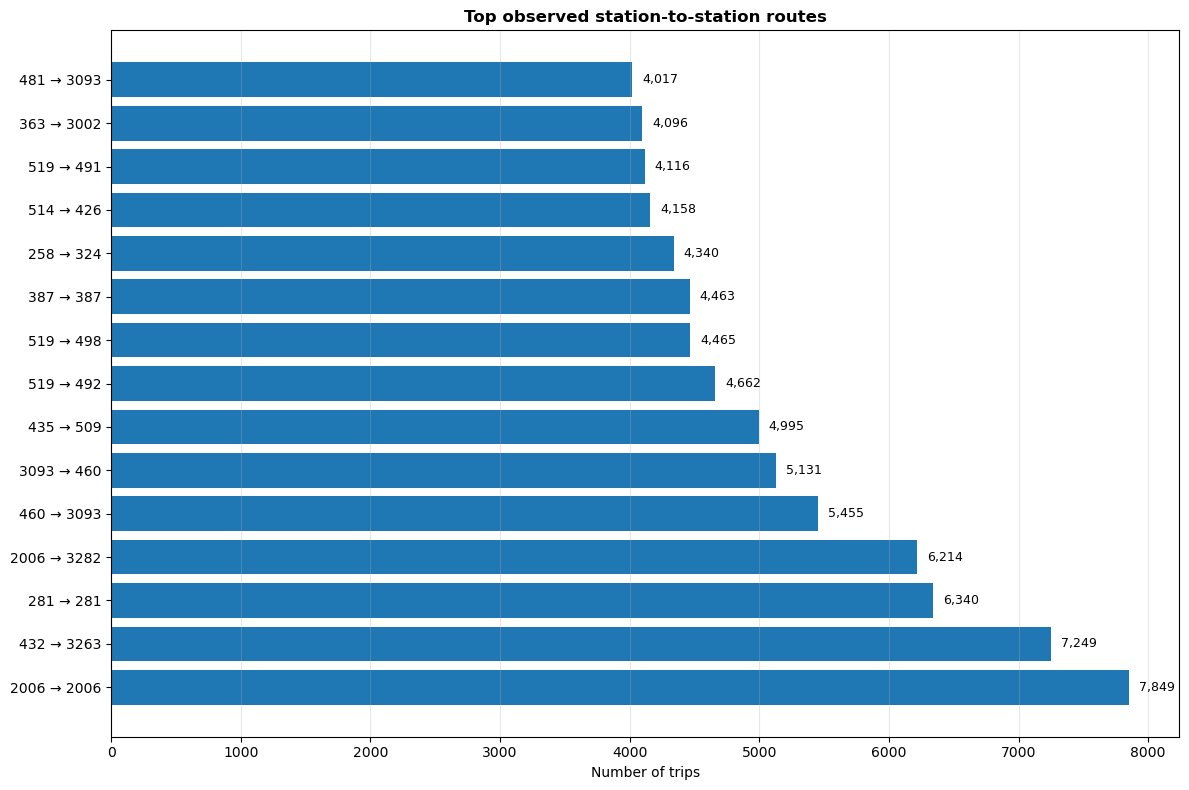


--- GRAPH 2: BIDIRECTIONAL ROUTE PAIRS ---


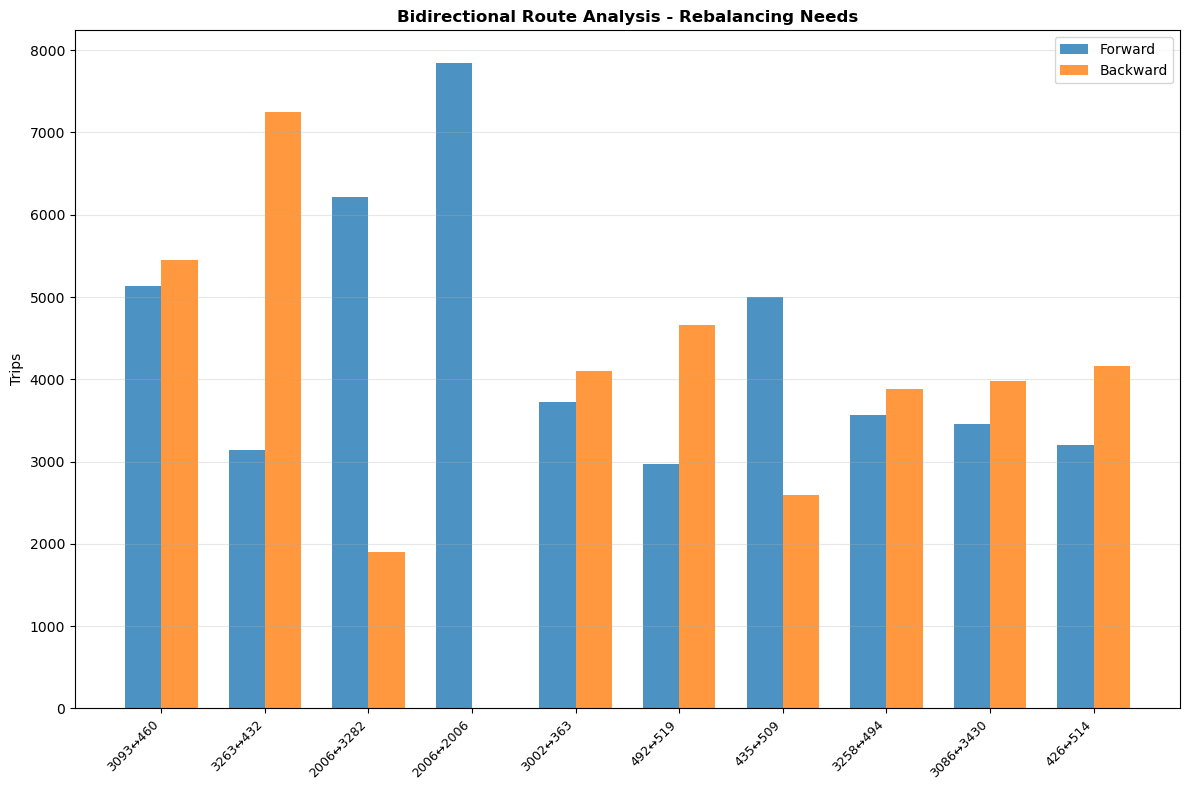


--- GRAPH 3: ZONE-TO-ZONE MOVEMENT PATTERNS ---


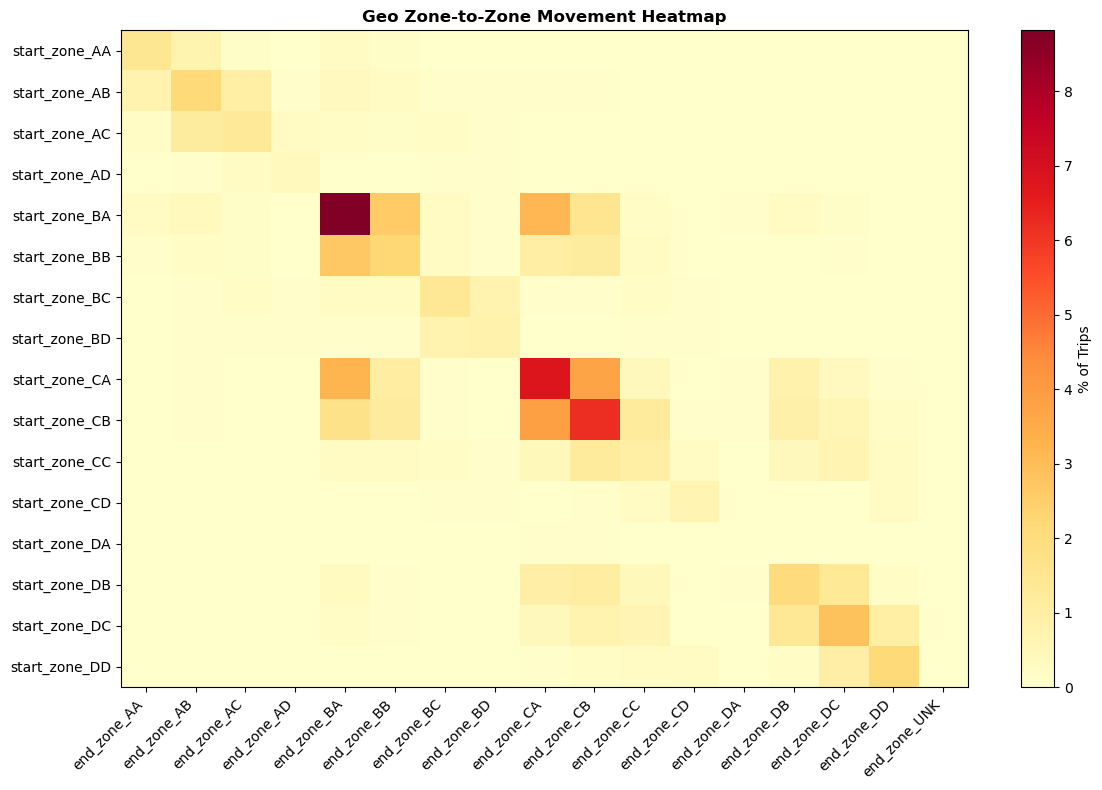


--- GRAPH 4: ASSOCIATION RULE PAIRS ---


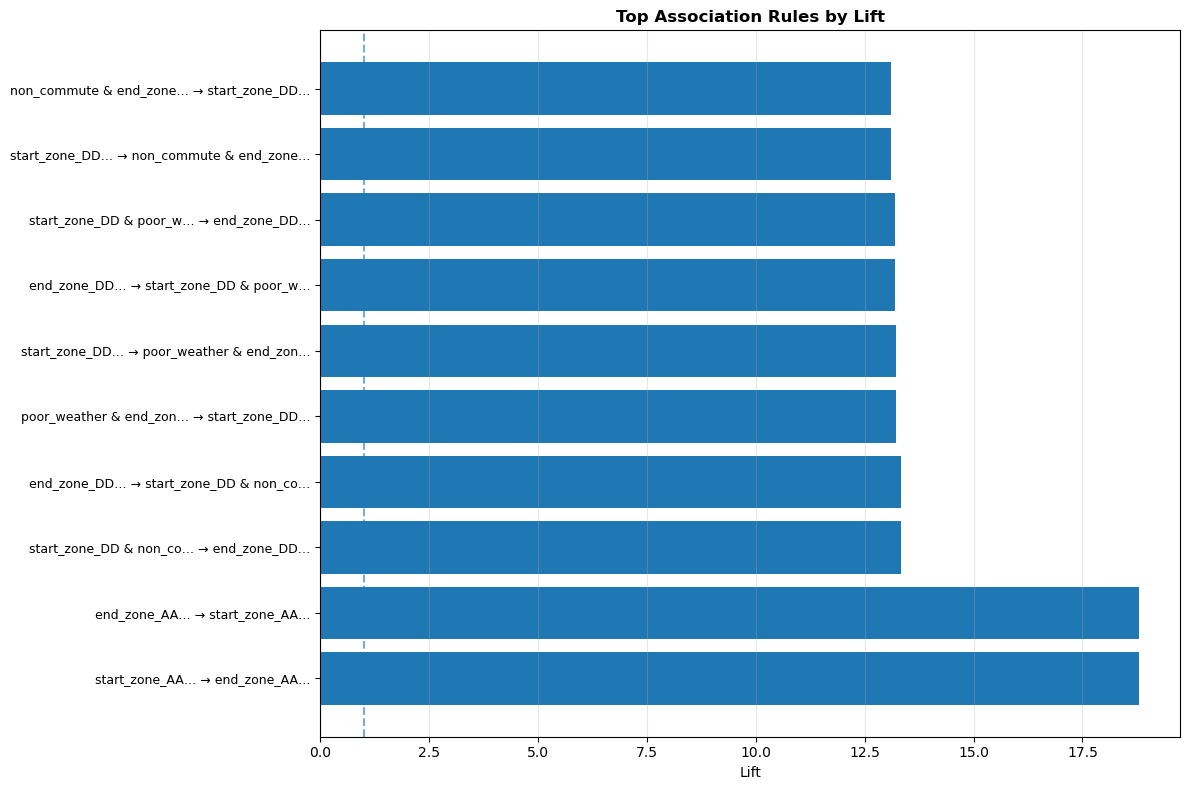


--- GRAPH 5: COMMUTE PATTERN DISTRIBUTION ---


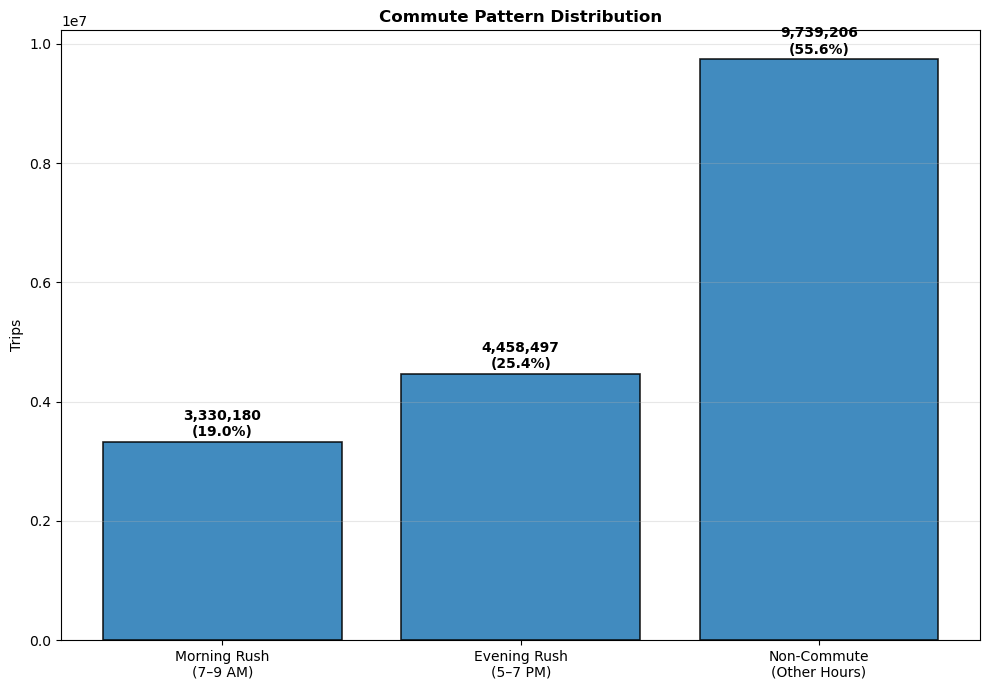


SUMMARY: ALL DISCOVERED PAIRS AND PATTERNS
1. Station Pairs:       347,178
2. Bidirectional Pairs: 200,466
3. Zone Connections:    268
4. Association Rules:   258
5. Frequent Itemsets:   278

Key Insights:
- Rush hours account for 44.4% of trips
- Top route carries 0.04% of total traffic
- Rebalancing needed for 4 of top 10 bidirectional pairs


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

print("\n" + "="*70)
print("FULL PIPELINE: PATTERN MINING + VISUALIZATIONS")
print("="*70)

# ------------------------------------------------------------
# A) CHECK IF WE ALREADY MINED RESULTS
# ------------------------------------------------------------
needed_vars = ["simplified_trans", "frequent_itemsets", "rules",
               "commute_patterns", "weather_patterns",
               "route_counter", "all_transactions"]

missing = [v for v in needed_vars if v not in globals()]

if missing:
    print(f"\nMining results missing: {missing}")
    print("→ Running mining step now...\n")

    # -------------------------------------------------------
    # 0) Top routes from FULL dataset (descriptive only)
    # -------------------------------------------------------
    top_10_routes = sorted(route_counter.items(), key=lambda x: x[1], reverse=True)[:10]

    print("\nTop 10 Most Frequent Routes (Full Dataset):")
    total_trips = max(len(all_transactions), 1)
    for i, (route, count) in enumerate(top_10_routes, 1):
        s1, s2 = route.split("_to_")
        pct = count / total_trips * 100
        print(f"  {i:2}. {s1} → {s2}: {count:,} trips ({pct:.2f}%)")


    # -------------------------------------------------------
    # 1) Build GEO zones once (quantile grid on lat/lon)
    # -------------------------------------------------------
    stations_geo = (
        dfm[["start_station_id", "start_station_latitude", "start_station_longitude"]]
        .dropna()
        .drop_duplicates()
    )

    stations_geo["lat_q"] = pd.qcut(
        stations_geo["start_station_latitude"], q=4, labels=["A", "B", "C", "D"]
    )
    stations_geo["lon_q"] = pd.qcut(
        stations_geo["start_station_longitude"], q=4, labels=["A", "B", "C", "D"]
    )

    stations_geo["geo_zone"] = stations_geo["lat_q"].astype(str) + stations_geo["lon_q"].astype(str)
    zone_map = dict(zip(stations_geo["start_station_id"].astype(int), stations_geo["geo_zone"]))


    # -------------------------------------------------------
    # 2) Simplify ALL transactions (NO sampling)
    # -------------------------------------------------------
    def simplify_transactions_full(transactions_list, zone_map):
        simplified = []
        for trans in transactions_list:
            simple_trans = []
            for item in trans:
                if item in {"morning_commute", "evening_commute", "non_commute"}:
                    simple_trans.append(item)
                elif item in {"good_weather", "poor_weather"}:
                    simple_trans.append(item)
                elif item.startswith("start_"):
                    try:
                        sid = int(item.split("_")[1])
                        z = zone_map.get(sid, "UNK")
                        simple_trans.append(f"start_zone_{z}")
                    except:
                        pass
                elif item.startswith("end_"):
                    try:
                        sid = int(item.split("_")[1])
                        z = zone_map.get(sid, "UNK")
                        simple_trans.append(f"end_zone_{z}")
                    except:
                        pass
            if simple_trans:
                simplified.append(simple_trans)
        return simplified

    print("Creating simplified transactions from ALL trips...")
    simplified_trans = simplify_transactions_full(all_transactions, zone_map)
    print(f"Transactions for mining: {len(simplified_trans):,} / {len(all_transactions):,}")


    # -------------------------------------------------------
    # 3) Sparse one-hot encoding
    # -------------------------------------------------------
    print("Sparse encoding transactions...")
    te = TransactionEncoder()
    te_ary_sparse = te.fit(simplified_trans).transform(simplified_trans, sparse=True)

    df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary_sparse, columns=te.columns_)
    print(f"Encoded matrix shape: {df_encoded.shape}")
    print(f"Unique simplified items: {len(te.columns_)}")


    # -------------------------------------------------------
    # 4) Mine frequent itemsets on FULL dataset
    # -------------------------------------------------------
    MIN_SUPPORT = 0.01
    MAX_LEN = 3  

    try:
        print("Running Apriori (sparse, full data)...")
        frequent_itemsets = apriori(
            df_encoded,
            min_support=MIN_SUPPORT,
            use_colnames=True,
            max_len=MAX_LEN,
            low_memory=True
        )
        algo_used = "apriori"
    except MemoryError:
        print("⚠️ Apriori OOM. Falling back to FP-Growth...")
        frequent_itemsets = fpgrowth(
            df_encoded,
            min_support=MIN_SUPPORT,
            use_colnames=True,
            max_len=MAX_LEN
        )
        algo_used = "fpgrowth"

    print(f"Frequent patterns found ({algo_used}): {len(frequent_itemsets)}")


    # -------------------------------------------------------
    # 5) Association rules
    # -------------------------------------------------------
    if len(frequent_itemsets) > 1:
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
        rules = rules.sort_values("lift", ascending=False)
        print(f"Association rules generated: {len(rules)}")
    else:
        rules = pd.DataFrame()
        print("Not enough frequent patterns for association rules.")


    # -------------------------------------------------------
    # 6) Full-dataset descriptive pattern counts
    # -------------------------------------------------------
    commute_patterns = {"morning": 0, "evening": 0, "non_commute": 0}
    weather_patterns = {"good": 0, "poor": 0}

    for trans in all_transactions:
        s = set(trans)
        if "morning_commute" in s:
            commute_patterns["morning"] += 1
        elif "evening_commute" in s:
            commute_patterns["evening"] += 1
        else:
            commute_patterns["non_commute"] += 1

        if "good_weather" in s:
            weather_patterns["good"] += 1
        else:
            weather_patterns["poor"] += 1

    total_trans = max(len(all_transactions), 1)

    print("\nCommute Patterns:")
    print(f"  Morning rush: {commute_patterns['morning']:,} ({commute_patterns['morning']/total_trans*100:.1f}%)")
    print(f"  Evening rush: {commute_patterns['evening']:,} ({commute_patterns['evening']/total_trans*100:.1f}%)")
    print(f"  Non-commute : {commute_patterns['non_commute']:,} ({commute_patterns['non_commute']/total_trans*100:.1f}%)")

    print("\nWeather Impact:")
    print(f"  Good weather trips: {weather_patterns['good']:,} ({weather_patterns['good']/total_trans*100:.1f}%)")
    print(f"  Poor weather trips: {weather_patterns['poor']:,} ({weather_patterns['poor']/total_trans*100:.1f}%)")

else:
    print("Mining results already exist")
    total_trans = max(len(all_transactions), 1)


# =====================================================
# B) VISUALIZATIONS
# =====================================================
print("\n" + "="*70)
print("COMPREHENSIVE PATTERN ANALYSIS WITH VISUALIZATIONS")
print("="*70)

# -----------------------------------------------------
# GRAPH 1: TOP STATION ROUTES
# -----------------------------------------------------
print("\n--- GRAPH 1: TOP STATION-TO-STATION ROUTES ---")
top_15_routes = sorted(route_counter.items(), key=lambda x: x[1], reverse=True)[:15]
route_labels = [r.replace("_to_", " → ") for r, _ in top_15_routes]
route_counts = [c for _, c in top_15_routes]

plt.figure(figsize=(12, 8))
plt.barh(range(len(route_labels)), route_counts)
plt.yticks(range(len(route_labels)), route_labels, fontsize=10)
plt.xlabel("Number of trips")
plt.title("Top observed station-to-station routes", fontweight="bold")
for i, count in enumerate(route_counts):
    plt.text(count + max(route_counts)*0.01, i, f"{count:,}", va="center", fontsize=9)
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# GRAPH 2: BIDIRECTIONAL PAIRS
# -----------------------------------------------------
print("\n--- GRAPH 2: BIDIRECTIONAL ROUTE PAIRS ---")
bidirectional_pairs = {}
for route, count in route_counter.items():
    s1, s2 = route.split("_to_")
    key = tuple(sorted([s1, s2]))
    if key not in bidirectional_pairs:
        bidirectional_pairs[key] = {"forward": 0, "backward": 0, "total": 0}
    if (s1, s2) == key:
        bidirectional_pairs[key]["forward"] += count
    else:
        bidirectional_pairs[key]["backward"] += count
    bidirectional_pairs[key]["total"] += count

top_pairs = sorted(bidirectional_pairs.items(), key=lambda x: x[1]["total"], reverse=True)[:10]

pair_labels     = [f"{s1}↔{s2}" for (s1, s2), _ in top_pairs]
forward_counts  = [c["forward"] for _, c in top_pairs]
backward_counts = [c["backward"] for _, c in top_pairs]

x = np.arange(len(pair_labels))
width = 0.35

plt.figure(figsize=(12, 8))
plt.bar(x - width/2, forward_counts, width, label="Forward", alpha=0.8)
plt.bar(x + width/2, backward_counts, width, label="Backward", alpha=0.8)
plt.xticks(x, pair_labels, rotation=45, ha="right", fontsize=9)
plt.ylabel("Trips")
plt.title("Bidirectional Route Analysis - Rebalancing Needs", fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# GRAPH 3: GEO ZONE FLOW HEATMAP
# -----------------------------------------------------
print("\n--- GRAPH 3: ZONE-TO-ZONE MOVEMENT PATTERNS ---")
zone_connections = {}
for trans in simplified_trans:
    start_zones = [item for item in trans if item.startswith("start_zone_")]
    end_zones   = [item for item in trans if item.startswith("end_zone_")]
    for start in start_zones:
        for end in end_zones:
            pair = f"{start} → {end}"
            zone_connections[pair] = zone_connections.get(pair, 0) + 1

start_zone_vals = sorted({z for t in simplified_trans for z in t if z.startswith("start_zone_")})
end_zone_vals   = sorted({z for t in simplified_trans for z in t if z.startswith("end_zone_")})

matrix = np.zeros((len(start_zone_vals), len(end_zone_vals)))
for pair, count in zone_connections.items():
    start, end = pair.split(" → ")
    i = start_zone_vals.index(start)
    j = end_zone_vals.index(end)
    matrix[i, j] = count

matrix_pct = (matrix / matrix.sum()) * 100 if matrix.sum() > 0 else matrix

plt.figure(figsize=(12, 8))
im = plt.imshow(matrix_pct, cmap="YlOrRd", aspect="auto")
plt.colorbar(im, label="% of Trips")
plt.xticks(range(len(end_zone_vals)), end_zone_vals, rotation=45, ha="right")
plt.yticks(range(len(start_zone_vals)), start_zone_vals)
plt.title("Geo Zone-to-Zone Movement Heatmap", fontweight="bold")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# GRAPH 4: ASSOCIATION RULES (TOP LIFT)
# -----------------------------------------------------
print("\n--- GRAPH 4: ASSOCIATION RULE PAIRS ---")
if len(rules) > 0:
    top_rules = rules.nlargest(10, "lift")
    rule_labels = [
        f'{" & ".join(list(r["antecedents"]))[:22]}… → {" & ".join(list(r["consequents"]))[:22]}…'
        for _, r in top_rules.iterrows()
    ]
    lifts = top_rules["lift"].values

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(rule_labels)), lifts)
    plt.yticks(range(len(rule_labels)), rule_labels, fontsize=9)
    plt.xlabel("Lift")
    plt.title("Top Association Rules by Lift", fontweight="bold")
    plt.axvline(1, linestyle="--", alpha=0.6)
    plt.grid(True, alpha=0.3, axis="x")
    plt.tight_layout()
    plt.show()
else:
    print("No association rules found.")


# -----------------------------------------------------
# GRAPH 5: COMMUTE DISTRIBUTION
# -----------------------------------------------------
print("\n--- GRAPH 5: COMMUTE PATTERN DISTRIBUTION ---")
categories = ["Morning Rush\n(7–9 AM)", "Evening Rush\n(5–7 PM)", "Non-Commute\n(Other Hours)"]
values = [commute_patterns["morning"], commute_patterns["evening"], commute_patterns["non_commute"]]

plt.figure(figsize=(10, 7))
bars = plt.bar(range(3), values, alpha=0.85, edgecolor="black", linewidth=1.2)
plt.xticks(range(3), categories)
plt.ylabel("Trips")
plt.title("Commute Pattern Distribution", fontweight="bold")
plt.grid(True, alpha=0.3, axis="y")

for bar, value in zip(bars, values):
    pct = value / total_trans * 100
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + max(values)*0.01,
             f"{value:,}\n({pct:.1f}%)",
             ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()


# -----------------------------------------------------
# FINAL SUMMARY
# -----------------------------------------------------
print("\n" + "="*70)
print("SUMMARY: ALL DISCOVERED PAIRS AND PATTERNS")
print("="*70)

print(f"1. Station Pairs:       {len(route_counter):,}")
print(f"2. Bidirectional Pairs: {len(bidirectional_pairs):,}")
print(f"3. Zone Connections:    {len(zone_connections):,}")
print(f"4. Association Rules:   {len(rules):,}")
print(f"5. Frequent Itemsets:   {len(frequent_itemsets):,}")

rush_pct = (commute_patterns["morning"] + commute_patterns["evening"]) / total_trans * 100
top_route_pct = (top_15_routes[0][1] / total_trans * 100) if top_15_routes else 0
imbalanced_pairs = sum(
    1 for (_, c) in top_pairs
    if c["total"] > 0 and abs(c["forward"] - c["backward"]) / c["total"] > 0.3
)

print("\nKey Insights:")
print(f"- Rush hours account for {rush_pct:.1f}% of trips")
print(f"- Top route carries {top_route_pct:.2f}% of total traffic")
print(f"- Rebalancing needed for {imbalanced_pairs} of top 10 bidirectional pairs")


## 📍 Visualize Top Routes on Map

Map the most frequent routes to see their real-world locations in NYC

In [12]:
# Extract top 10 routes and get their station coordinates
print("=" * 60)
print("TOP 10 MOST FREQUENT ROUTES - GEOGRAPHIC MAPPING")
print("=" * 60)

# Parse the top routes to get station IDs
route_data = []
for route, count in top_10_routes:
    # Route format is "start_to_end"
    parts = route.split("_to_")
    if len(parts) == 2:
        start_id = int(parts[0])
        end_id = int(parts[1])
        route_data.append({
            'route': route,
            'start_id': start_id,
            'end_id': end_id,
            'count': count,
            'pct': (count / total_trips * 100)
        })

routes_df = pd.DataFrame(route_data)

# Merge with station coordinates
routes_with_coords = routes_df.merge(
    stations[['start_station_id', 'start_station_latitude', 'start_station_longitude']],
    left_on='start_id',
    right_on='start_station_id',
    how='left'
).merge(
    stations[['start_station_id', 'start_station_latitude', 'start_station_longitude']],
    left_on='end_id',
    right_on='start_station_id',
    how='left',
    suffixes=('_start', '_end')
)

print(f"\n✓ Mapped {len(routes_with_coords)} routes to coordinates")
print("\nRoute Details:")
for idx, row in routes_with_coords.iterrows():
    same_station = "⭕ SAME STATION" if row['start_id'] == row['end_id'] else "→"
    print(f"{idx+1}. Station {row['start_id']} {same_station} {row['end_id']}: "
          f"{row['count']:,} trips ({row['pct']:.3f}%)")
    if row['start_id'] != row['end_id']:
        print(f"   From: ({row['start_station_latitude_start']:.4f}, {row['start_station_longitude_start']:.4f})")
        print(f"   To:   ({row['start_station_latitude_end']:.4f}, {row['start_station_longitude_end']:.4f})")
    else:
        print(f"   At:   ({row['start_station_latitude_start']:.4f}, {row['start_station_longitude_start']:.4f})")

routes_with_coords.head(10)

TOP 10 MOST FREQUENT ROUTES - GEOGRAPHIC MAPPING

✓ Mapped 10 routes to coordinates

Route Details:
1. Station 2006 ⭕ SAME STATION 2006: 7,849 trips (0.045%)
   At:   (40.7659, -73.9763)
2. Station 432 → 3263: 7,249 trips (0.041%)
   From: (40.7262, -73.9838)
   To:   (40.7295, -73.9908)
3. Station 281 ⭕ SAME STATION 281: 6,340 trips (0.036%)
   At:   (40.7644, -73.9737)
4. Station 2006 → 3282: 6,214 trips (0.035%)
   From: (40.7659, -73.9763)
   To:   (40.7831, -73.9594)
5. Station 460 → 3093: 5,455 trips (0.031%)
   From: (40.7129, -73.9659)
   To:   (40.7175, -73.9585)
6. Station 3093 → 460: 5,131 trips (0.029%)
   From: (40.7175, -73.9585)
   To:   (40.7129, -73.9659)
7. Station 435 → 509: 4,995 trips (0.028%)
   From: (40.7417, -73.9942)
   To:   (40.7455, -74.0020)
8. Station 519 → 492: 4,662 trips (0.027%)
   From: (40.7519, -73.9777)
   To:   (40.7502, -73.9909)
9. Station 519 → 498: 4,465 trips (0.025%)
   From: (40.7519, -73.9777)
   To:   (40.7485, -73.9881)
10. Station 387 

,route,start_id,end_id,count,pct,start_station_id_start,start_station_latitude_start,start_station_longitude_start,start_station_id_end,start_station_latitude_end,start_station_longitude_end
0,2006_to_2006,2006,2006,7849,0.044780,2006.0,40.765909,-73.976342,2006.0,40.765909,-73.976342
1,432_to_3263,432,3263,7249,0.041357,432.0,40.726218,-73.983799,3263.0,40.729515,-73.990753
2,281_to_281,281,281,6340,0.036171,281.0,40.764397,-73.973715,281.0,40.764397,-73.973715
3,2006_to_3282,2006,3282,6214,0.035452,2006.0,40.765909,-73.976342,3282.0,40.783070,-73.959390
4,460_to_3093,460,3093,5455,0.031122,460.0,40.712859,-73.965903,3093.0,40.717452,-73.958509
5,3093_to_460,3093,460,5131,0.029273,3093.0,40.717452,-73.958509,460.0,40.712859,-73.965903
6,435_to_509,435,509,4995,0.028497,435.0,40.741740,-73.994156,509.0,40.745497,-74.001971
7,519_to_492,519,492,4662,0.026598,519.0,40.751873,-73.977706,492.0,40.750200,-73.990931
8,519_to_498,519,498,4465,0.025474,519.0,40.751873,-73.977706,498.0,40.748549,-73.988084
9,387_to_387,387,387,4463,0.025462,387.0,40.712733,-74.004607,387.0,40.712733,-74.004607


In [13]:
# Create a detailed analysis table correlating routes with real-world context
print("=" * 80)
print("ROUTE ANALYSIS: Real-World Context")
print("=" * 80)

# Analyze route characteristics
route_analysis = []
for idx, row in routes_with_coords.iterrows():
    # Calculate distance (rough estimate using lat/lon difference)
    if row['start_id'] == row['end_id']:
        distance_km = 0
        route_type = "Round Trip (Same Station)"
    else:
        lat_diff = abs(row['start_station_latitude_end'] - row['start_station_latitude_start'])
        lon_diff = abs(row['start_station_longitude_end'] - row['start_station_longitude_start'])
        # Rough conversion: 1 degree lat ≈ 111km, 1 degree lon ≈ 85km at NYC latitude
        distance_km = np.sqrt((lat_diff * 111)**2 + (lon_diff * 85)**2)
        
        if distance_km < 0.5:
            route_type = "Very Short (<0.5km)"
        elif distance_km < 2:
            route_type = "Short (0.5-2km)"
        elif distance_km < 5:
            route_type = "Medium (2-5km)"
        else:
            route_type = "Long (>5km)"
    
    route_analysis.append({
        'Rank': idx + 1,
        'Route': f"{row['start_id']} → {row['end_id']}",
        'Trips': f"{row['count']:,}",
        '% of Total': f"{row['pct']:.3f}%",
        'Distance (km)': f"{distance_km:.2f}",
        'Type': route_type,
        'Start Coords': f"({row['start_station_latitude_start']:.4f}, {row['start_station_longitude_start']:.4f})",
        'End Coords': f"({row['start_station_latitude_end']:.4f}, {row['start_station_longitude_end']:.4f})" if row['start_id'] != row['end_id'] else "Same"
    })

analysis_df = pd.DataFrame(route_analysis)
print("\n")
print(analysis_df.to_string(index=False))

# Summary statistics
print("\n" + "=" * 80)
print("INSIGHTS:")
print("=" * 80)
same_station = sum(1 for r in route_analysis if r['Distance (km)'] == '0.00')
print(f"• {same_station}/10 routes are round trips (same start/end station)")

if same_station < 10:
    print(f"\n• {10-same_station}/10 routes are one-way trips")
    print(f"  - Likely commuter routes or point-to-point transportation")
    
# Check if we can identify any patterns
total_top10_trips = sum(r['count'] for r in route_data)
print(f"\n• Top 10 routes combined: {total_top10_trips:,} trips ({total_top10_trips/total_trips*100:.2f}% of all trips)")
print(f"• Average trips per top route: {total_top10_trips/10:,.0f}")

ROUTE ANALYSIS: Real-World Context


 Rank       Route Trips % of Total Distance (km)                      Type        Start Coords          End Coords
    1 2006 → 2006 7,849     0.045%          0.00 Round Trip (Same Station) (40.7659, -73.9763)                Same
    2  432 → 3263 7,249     0.041%          0.70           Short (0.5-2km) (40.7262, -73.9838) (40.7295, -73.9908)
    3   281 → 281 6,340     0.036%          0.00 Round Trip (Same Station) (40.7644, -73.9737)                Same
    4 2006 → 3282 6,214     0.035%          2.39            Medium (2-5km) (40.7659, -73.9763) (40.7831, -73.9594)
    5  460 → 3093 5,455     0.031%          0.81           Short (0.5-2km) (40.7129, -73.9659) (40.7175, -73.9585)
    6  3093 → 460 5,131     0.029%          0.81           Short (0.5-2km) (40.7175, -73.9585) (40.7129, -73.9659)
    7   435 → 509 4,995     0.028%          0.78           Short (0.5-2km) (40.7417, -73.9942) (40.7455, -74.0020)
    8   519 → 492 4,662     0.027%         

In [14]:
dfm.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,temp_category,is_dry,wind_kmh,sky_condition,visibility_km,cycling_score,day_of_week,is_weekend,hour,month
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,...,freezing,1,73.439995,clear,NaN,20.025681,0,0,13,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,...,freezing,1,70.919998,cloudy,NaN,20.049688,0,0,15,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,...,freezing,1,70.919998,cloudy,NaN,20.049688,0,0,15,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,...,freezing,1,70.919998,cloudy,NaN,20.049688,0,0,15,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,...,freezing,1,26.639999,clear,NaN,20.008514,0,0,18,1


## Finalize User Profiles

In [15]:
print("\n" + "="*70)
print("USER CLUSTERING - AGGREGATING PROFILES")
print("="*70)

# Combine all batch profiles
all_profiles = pd.concat(user_profiles_list, ignore_index=True)

# Final aggregation
user_profiles = all_profiles.groupby(['birth_year', 'gender']).agg({
    ('tripduration', 'mean'): 'mean',
    ('tripduration', 'std'): 'mean',
    ('tripduration', 'count'): 'sum',
    ('trip_duration_min', 'mean'): 'mean',
    ('trip_duration_min', 'median'): 'mean',
    ('start_station_id', 'nunique'): 'max',
    ('end_station_id', 'nunique'): 'max',
    ('hour', 'mean'): 'mean',
    ('hour', 'std'): 'mean',
    ('is_weekend', 'mean'): 'mean',
    ('day_of_week', '<lambda>'): 'mean',
    ('cycling_score', 'mean'): 'mean',
    ('cycling_score', 'std'): 'mean',
    ('temp_celsius', 'mean'): 'mean',
    ('is_dry', 'mean'): 'mean',
    ('usertype', '<lambda>'): 'mean'
}).reset_index()

# Rename columns
user_profiles.columns = [
    'birth_year', 'gender', 'avg_duration', 'std_duration', 'trip_count',
    'avg_trip_min', 'median_trip_min', 'unique_start_stations', 'unique_end_stations',
    'avg_hour', 'std_hour', 'weekend_ratio', 'preferred_day',
    'avg_cycling_score', 'std_cycling_score', 'avg_temp_preference', 
    'dry_weather_ratio', 'is_subscriber'
]

# Add derived features
user_profiles['age'] = 2018 - user_profiles['birth_year']
user_profiles['station_diversity'] = (user_profiles['unique_start_stations'] + 
                                      user_profiles['unique_end_stations']) / 2
user_profiles['trips_per_month'] = user_profiles['trip_count'] / 3

# Clean data
user_profiles_clean = user_profiles.dropna()
print(f"User profiles created: {len(user_profiles_clean)} unique user groups")
print(f"From {user_profiles_clean['trip_count'].sum():.0f} total trips")


USER CLUSTERING - AGGREGATING PROFILES
User profiles created: 212 unique user groups
From 17527880 total trips


# Hierarchical Clustering


In [16]:
print("\n" + "="*70)
print("HIERARCHICAL CLUSTERING ANALYSIS (CPU)")
print("="*70)

# Select features
clustering_features = [
    'age', 'avg_duration', 'trip_count', 'station_diversity',
    'avg_trip_min', 'weekend_ratio', 'avg_hour',
    'avg_cycling_score', 'dry_weather_ratio', 'trips_per_month'
]

available_features = [col for col in clustering_features if col in user_profiles_clean.columns]
X = user_profiles_clean[available_features].values


# CPU Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Clustering matrix: {X_scaled.shape}")

# Find best linkage method
linkage_methods = ['ward', 'average', 'complete']
best_method = None
best_score = float('inf')

for method in linkage_methods:
    linkage_test = linkage(X_scaled, method=method)
    clusters_test = fcluster(linkage_test, 4, criterion='maxclust')
    db_score = davies_bouldin_score(X_scaled, clusters_test)
    print(f"  {method}: Davies-Bouldin = {db_score:.3f}")
    if db_score < best_score:
        best_score = db_score
        best_method = method

print(f"\nBest method: {best_method}")

# Perform clustering
linkage_matrix = linkage(X_scaled, method=best_method)

# Find optimal k
db_scores = []
sil_scores = []
k_range = range(3, 9)

for k in k_range:
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    db = davies_bouldin_score(X_scaled, clusters)
    sil = silhouette_score(X_scaled, clusters)
    db_scores.append(db)
    sil_scores.append(sil)
    print(f"  k={k}: DB={db:.3f}, Silhouette={sil:.3f}")

optimal_k = k_range[np.argmin(db_scores)]
print(f"\nOptimal clusters: {optimal_k}")

# Final clustering
final_clusters = fcluster(linkage_matrix, optimal_k, criterion='maxclust')
user_profiles_clean['cluster'] = final_clusters

print(f"Acceleration: CPU (scikit-learn + scipy)")


HIERARCHICAL CLUSTERING ANALYSIS (CPU)
Clustering matrix: (212, 10)
  ward: Davies-Bouldin = 1.282
  average: Davies-Bouldin = 0.176
  complete: Davies-Bouldin = 0.589

Best method: average
  k=3: DB=0.178, Silhouette=0.726
  k=4: DB=0.176, Silhouette=0.714
  k=5: DB=0.180, Silhouette=0.698
  k=6: DB=0.409, Silhouette=0.634
  k=7: DB=0.205, Silhouette=0.616
  k=8: DB=0.238, Silhouette=0.486

Optimal clusters: 4
Acceleration: CPU (scikit-learn + scipy)


C:\Users\rishi\AppData\Local\Temp\ipykernel_20680\2199929995.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profiles_clean['cluster'] = final_clusters


# Visualize Clustering Results


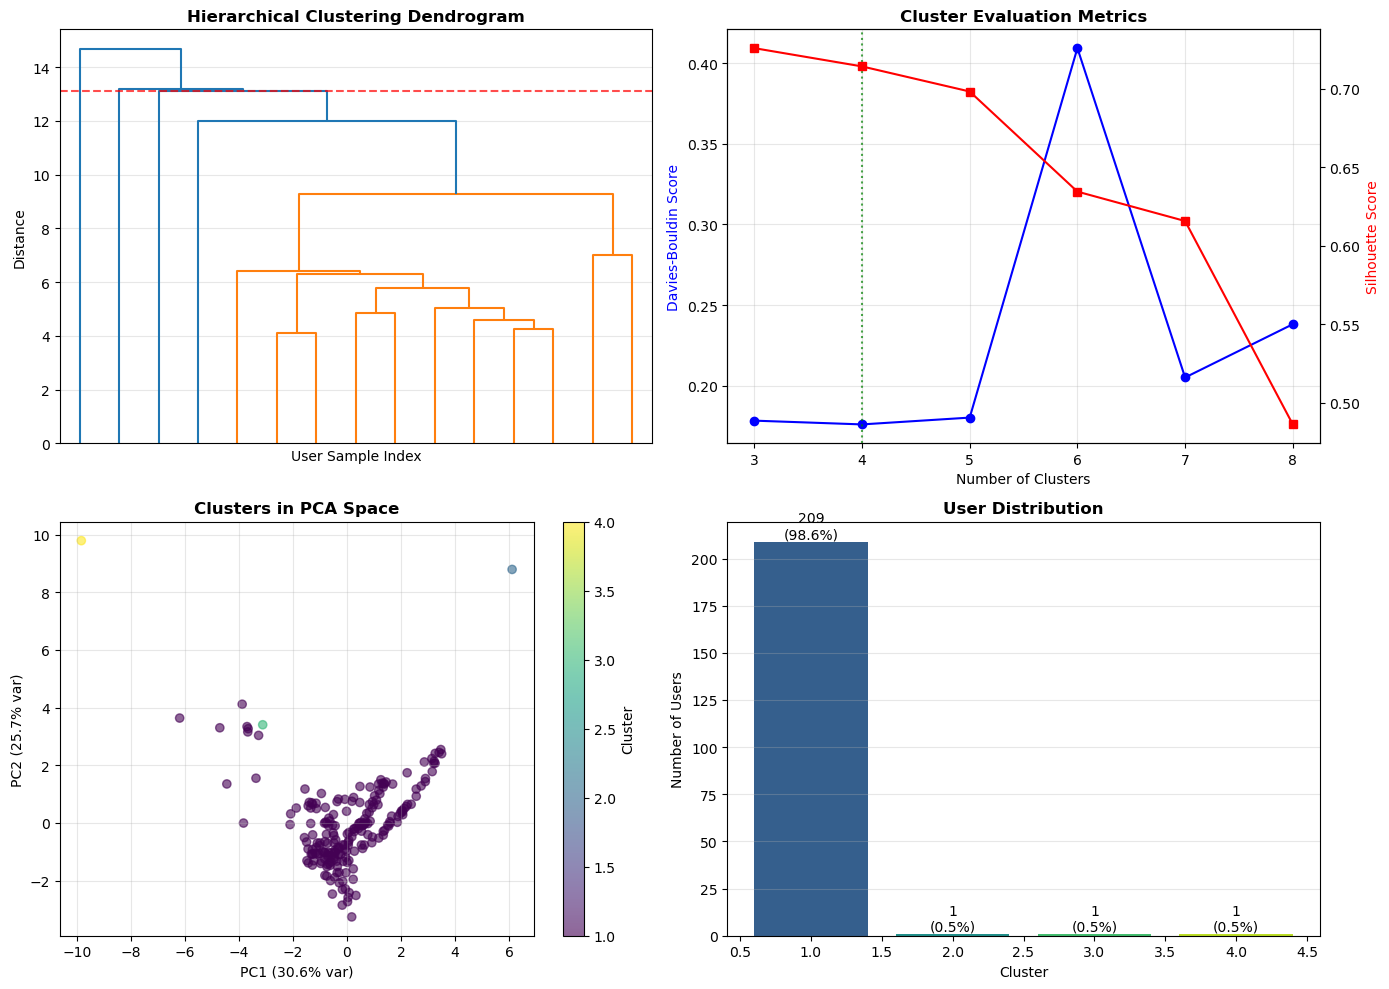

In [17]:
# Add these imports at the top of your notebook
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np

# Then run your visualization code
fig = plt.figure(figsize=(14, 10))

# Dendrogram
ax1 = plt.subplot(2, 2, 1)
dendrogram(linkage_matrix, truncate_mode='lastp', p=15, no_labels=True, ax=ax1)
ax1.axhline(y=linkage_matrix[-(optimal_k-1), 2], color='r', linestyle='--', alpha=0.7)
ax1.set_title('Hierarchical Clustering Dendrogram', fontweight='bold')
ax1.set_xlabel('User Sample Index')
ax1.set_ylabel('Distance')
ax1.grid(True, alpha=0.3)

# Metrics
ax2 = plt.subplot(2, 2, 2)
k_range_plot = list(range(3, 3 + len(db_scores)))
ax2.plot(k_range_plot, db_scores, 'b-o', label='Davies-Bouldin')
ax2_twin = ax2.twinx()
ax2_twin.plot(k_range_plot, sil_scores, 'r-s', label='Silhouette')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Davies-Bouldin Score', color='b')
ax2_twin.set_ylabel('Silhouette Score', color='r')
ax2.axvline(x=optimal_k, color='green', linestyle=':', alpha=0.7)
ax2.set_title('Cluster Evaluation Metrics', fontweight='bold')
ax2.grid(True, alpha=0.3)

# PCA visualization
ax3 = plt.subplot(2, 2, 3)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=final_clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ax=ax3, label='Cluster')
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax3.set_title('Clusters in PCA Space', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Distribution
ax4 = plt.subplot(2, 2, 4)
cluster_sizes = user_profiles_clean['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(cluster_sizes)))
bars = ax4.bar(cluster_sizes.index, cluster_sizes.values, color=colors)
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Number of Users')
ax4.set_title('User Distribution', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, cluster_sizes.values):
    pct = count / len(user_profiles_clean) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{count}\n({pct:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Analyze Clusters

In [18]:
# Analyze each cluster
for cluster_id in range(1, optimal_k + 1):
    cluster = user_profiles_clean[user_profiles_clean['cluster'] == cluster_id]
    
    print(f"\nCLUSTER {cluster_id}: {len(cluster)} users ({len(cluster)/len(user_profiles_clean)*100:.1f}%)")
    print("-" * 50)
    print(f"Age: {cluster['age'].mean():.1f} years")
    print(f"Trips/month: {cluster['trips_per_month'].mean():.1f}")
    print(f"Trip duration: {cluster['avg_trip_min'].mean():.1f} min")
    print(f"Weekend usage: {cluster['weekend_ratio'].mean():.1%}")
    print(f"Station diversity: {cluster['station_diversity'].mean():.1f}")
    print(f"Weather score: {cluster['avg_cycling_score'].mean():.1f}/100")

# Summary table
cluster_summary = user_profiles_clean.groupby('cluster').agg({
    'age': 'mean',
    'trip_count': 'mean',
    'avg_trip_min': 'mean',
    'weekend_ratio': 'mean',
    'station_diversity': 'mean',
    'avg_cycling_score': 'mean'
}).round(2)

print("\n" + "="*70)
print("CLUSTER SUMMARY")
print("="*70)
print(cluster_summary)
print("\nAnalysis complete!")


CLUSTER 1: 209 users (98.6%)
--------------------------------------------------
Age: 51.0 years
Trips/month: 25754.3
Trip duration: 15.1 min
Weekend usage: 23.2%
Station diversity: 339.9
Weather score: 56.9/100

CLUSTER 2: 1 users (0.5%)
--------------------------------------------------
Age: 49.0 years
Trips/month: 459984.0
Trip duration: 26.1 min
Weekend usage: 41.4%
Station diversity: 764.5
Weather score: 58.3/100

CLUSTER 3: 1 users (0.5%)
--------------------------------------------------
Age: 88.0 years
Trips/month: 2.0
Trip duration: 13.2 min
Weekend usage: 83.3%
Station diversity: 3.0
Weather score: 34.8/100

CLUSTER 4: 1 users (0.5%)
--------------------------------------------------
Age: 73.0 years
Trips/month: 1.3
Trip duration: 60.5 min
Weekend usage: 100.0%
Station diversity: 3.0
Weather score: 57.5/100

CLUSTER SUMMARY
           age  trip_count  avg_trip_min  weekend_ratio  station_diversity  \
cluster                                                                     

# Temporal Demand Forecasting


TEMPORAL DEMAND ANALYSIS & PATTERNS

Peak vs Off-Peak Analysis:
        trip_duration_min       start_station_id usertype
                     mean   std            count <lambda>
is_peak                                                  
0                   14.61  24.1          9739206     0.86
1                   13.57  20.0          7788677     0.93


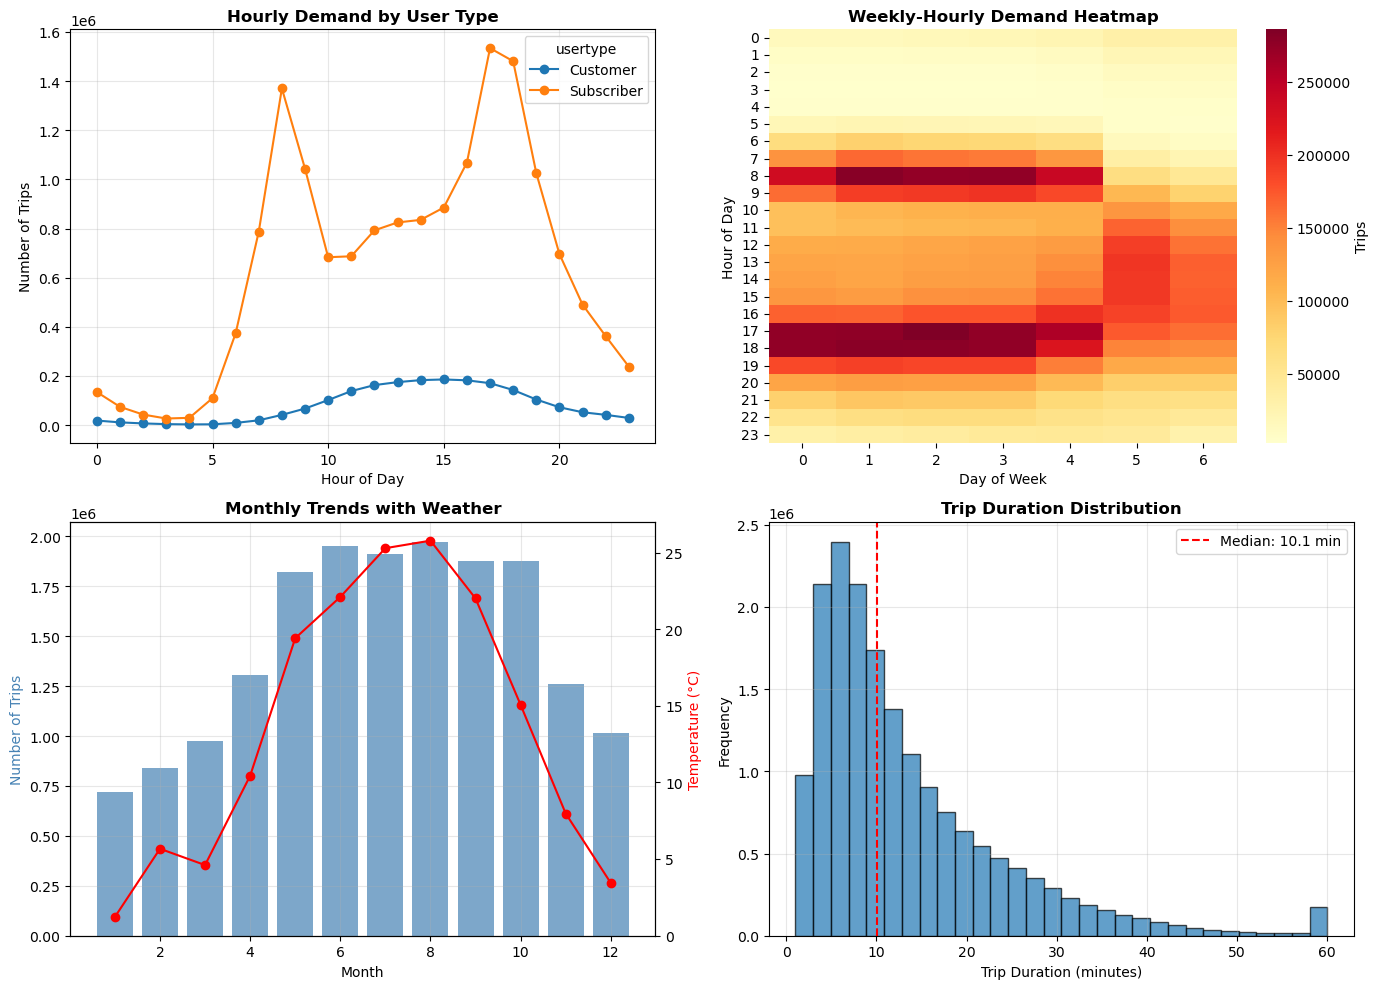

In [19]:
print("\n" + "="*70)
print("TEMPORAL DEMAND ANALYSIS & PATTERNS")
print("="*70)

# Hourly demand patterns by user type
hourly_patterns = dfm.groupby([dfm['start_hour'].dt.hour, 'usertype']).agg({
    'start_station_id': 'count',
    'trip_duration_min': 'mean',
    'cycling_score': 'mean'
}).rename(columns={'start_station_id': 'trips'}).reset_index()

# Peak vs Off-peak analysis
peak_hours = [7, 8, 9, 17, 18, 19]
dfm['is_peak'] = dfm['hour'].isin(peak_hours).astype(int)

peak_analysis = dfm.groupby('is_peak').agg({
    'trip_duration_min': ['mean', 'std'],
    'start_station_id': 'count',
    'usertype': lambda x: (x == 'Subscriber').mean()
}).round(2)

print("\nPeak vs Off-Peak Analysis:")
print(peak_analysis)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hourly pattern by user type
pivot_hourly = hourly_patterns.pivot(index='start_hour', columns='usertype', values='trips')
pivot_hourly.plot(ax=axes[0,0], marker='o')
axes[0,0].set_title('Hourly Demand by User Type', fontweight='bold')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Number of Trips')
axes[0,0].grid(True, alpha=0.3)

# Weekly pattern heatmap
weekly_hourly = dfm.groupby(['day_of_week', 'hour']).size().reset_index(name='trips')
weekly_pivot = weekly_hourly.pivot(index='hour', columns='day_of_week', values='trips')
sns.heatmap(weekly_pivot, cmap='YlOrRd', ax=axes[0,1], cbar_kws={'label': 'Trips'})
axes[0,1].set_title('Weekly-Hourly Demand Heatmap', fontweight='bold')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Hour of Day')

# Monthly trend
monthly_trend = dfm.groupby('month').agg({
    'start_station_id': 'count',
    'cycling_score': 'mean',
    'temp_celsius': 'mean'
}).rename(columns={'start_station_id': 'trips'})

ax1 = axes[1,0]
ax1.bar(monthly_trend.index, monthly_trend['trips'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Trips', color='steelblue')
ax1.set_title('Monthly Trends with Weather', fontweight='bold')
ax2 = ax1.twinx()
ax2.plot(monthly_trend.index, monthly_trend['temp_celsius'], 'r-o', label='Temperature')
ax2.set_ylabel('Temperature (°C)', color='red')
ax1.grid(True, alpha=0.3)

# Duration distribution
axes[1,1].hist(dfm['trip_duration_min'].clip(0, 60), bins=30, edgecolor='black', alpha=0.7)
axes[1,1].axvline(dfm['trip_duration_min'].median(), color='red', linestyle='--', label=f'Median: {dfm["trip_duration_min"].median():.1f} min')
axes[1,1].set_xlabel('Trip Duration (minutes)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Trip Duration Distribution', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Weather Correlation Analysis


PEARSON CORRELATION: WEATHER vs TRIP DEMAND

Pearson Correlation Coefficients (Weather vs Trip Count):
------------------------------------------------------------------------------------------
Variable                   Correlation      p-value    Significance        Strength
------------------------------------------------------------------------------------------
temp_celsius                    0.4425     0.00e+00             *** Moderate positive
apparent_temperature            0.4099     0.00e+00             *** Moderate positive
cycling_score                   0.3415    9.20e-238             *** Moderate positive
is_dry                          0.1279     3.36e-33             ***   Weak positive
wind_kmh                       -0.0141     1.88e-01            n.s.   Weak negative
cloud_cover                    -0.0310     3.80e-03              **   Weak negative
snowfall                       -0.0850     1.69e-15             ***   Weak negative
rain                           -0.12

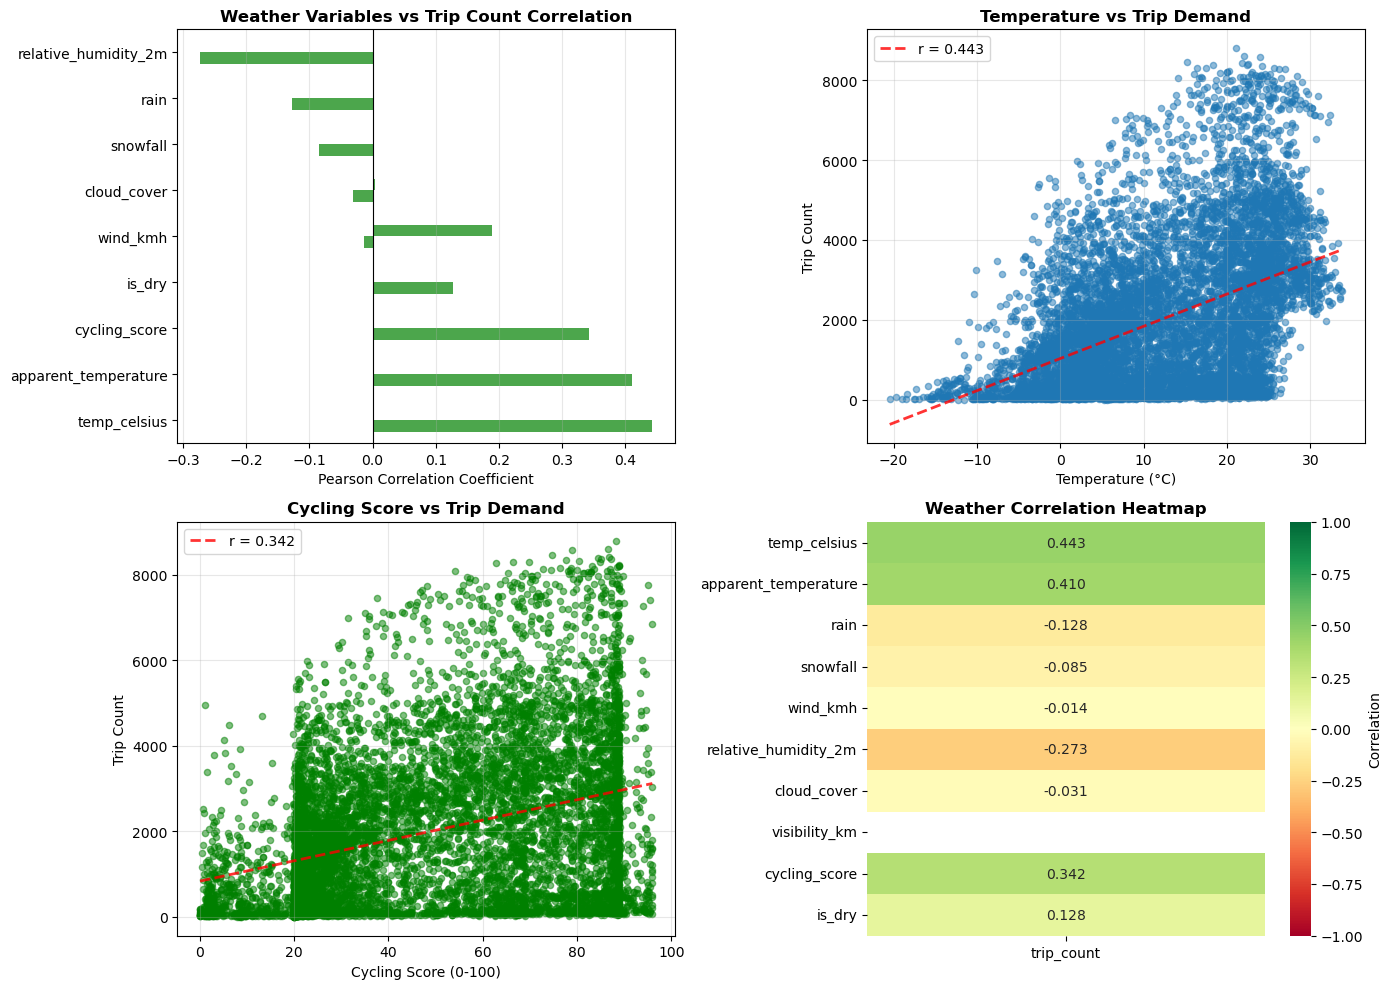


KEY INSIGHTS
✓ Strongest positive correlation: temp_celsius (r = 0.4425, p = 0.00e+00)
✓ Strongest negative correlation: relative_humidity_2m (r = -0.2730, p = 3.20e-149)
✓ 8 variables are statistically significant (p < 0.05)
✓ 3 variables show moderate-to-strong correlation (|r| > 0.3)
✓ Weather (cycling score) explains approximately 11.7% of trip demand variance (R² = 0.117)
✓ 7 variables are highly significant (p < 0.001), indicating robust relationships


In [20]:
print("\n" + "="*70)
print("PEARSON CORRELATION: WEATHER vs TRIP DEMAND")
print("="*70)

# Aggregate hourly trip counts with weather variables
hourly_data = dfm.groupby('start_hour').agg({
    'start_station_id': 'count',  # trip count
    'temp_celsius': 'mean',
    'apparent_temperature': 'mean',
    'rain': 'mean',
    'snowfall': 'mean',
    'wind_kmh': 'mean',
    'relative_humidity_2m': 'mean',
    'cloud_cover': 'mean',
    'visibility_km': 'mean',
    'cycling_score': 'mean',
    'is_dry': 'mean'
}).rename(columns={'start_station_id': 'trip_count'}).reset_index()

# Calculate Pearson correlation with p-values
from scipy.stats import pearsonr

weather_vars = [
    'temp_celsius', 'apparent_temperature', 'rain', 'snowfall', 
    'wind_kmh', 'relative_humidity_2m', 'cloud_cover', 
    'visibility_km', 'cycling_score', 'is_dry'
]

correlations = {}
p_values = {}

for var in weather_vars:
    if var in hourly_data.columns:
        # Remove NaN values for correlation calculation
        valid_mask = hourly_data[['trip_count', var]].notna().all(axis=1)
        if valid_mask.sum() > 2:  # Need at least 3 points for correlation
            corr, p_val = pearsonr(
                hourly_data.loc[valid_mask, 'trip_count'], 
                hourly_data.loc[valid_mask, var]
            )
            correlations[var] = corr
            p_values[var] = p_val

# Create DataFrame for better visualization
corr_df = pd.DataFrame({
    'Pearson Correlation': correlations,
    'p-value': p_values
})
corr_df['Significant'] = corr_df['p-value'] < 0.05
corr_df = corr_df.sort_values('Pearson Correlation', ascending=False)

print("\nPearson Correlation Coefficients (Weather vs Trip Count):")
print("-" * 90)
print(f"{'Variable':<25} {'Correlation':>12} {'p-value':>12} {'Significance':>15} {'Strength':>15}")
print("-" * 90)

for var, row in corr_df.iterrows():
    corr_value = row['Pearson Correlation']
    p_val = row['p-value']
    strength = "Strong" if abs(corr_value) > 0.5 else "Moderate" if abs(corr_value) > 0.3 else "Weak"
    direction = "positive" if corr_value > 0 else "negative"
    sig_marker = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
    
    print(f"{var:<25} {corr_value:>12.4f} {p_val:>12.2e} {sig_marker:>15} {strength + ' ' + direction:>15}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Correlation bar chart
ax1 = axes[0, 0]
colors = ['green' if x > 0 else 'red' for x in corr_df['Pearson Correlation']]
corr_df.plot(kind='barh', ax=ax1, legend=False, color=colors, alpha=0.7)
ax1.set_xlabel('Pearson Correlation Coefficient')
ax1.set_title('Weather Variables vs Trip Count Correlation', fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='x')

# 2. Temperature vs Trip Count scatter
ax2 = axes[0, 1]
ax2.scatter(hourly_data['temp_celsius'], hourly_data['trip_count'], alpha=0.5, s=20)
z = np.polyfit(hourly_data['temp_celsius'].dropna(), 
               hourly_data.loc[hourly_data['temp_celsius'].notna(), 'trip_count'], 1)
p = np.poly1d(z)
ax2.plot(hourly_data['temp_celsius'].sort_values(), 
         p(hourly_data['temp_celsius'].sort_values()), 
         "r--", alpha=0.8, linewidth=2, 
         label=f'r = {correlations["temp_celsius"]:.3f}')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Trip Count')
ax2.set_title('Temperature vs Trip Demand', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Cycling Score vs Trip Count
ax3 = axes[1, 0]
ax3.scatter(hourly_data['cycling_score'], hourly_data['trip_count'], alpha=0.5, s=20, color='green')
z = np.polyfit(hourly_data['cycling_score'].dropna(), 
               hourly_data.loc[hourly_data['cycling_score'].notna(), 'trip_count'], 1)
p = np.poly1d(z)
ax3.plot(hourly_data['cycling_score'].sort_values(), 
         p(hourly_data['cycling_score'].sort_values()), 
         "r--", alpha=0.8, linewidth=2, 
         label=f'r = {correlations["cycling_score"]:.3f}')
ax3.set_xlabel('Cycling Score (0-100)')
ax3.set_ylabel('Trip Count')
ax3.set_title('Cycling Score vs Trip Demand', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Correlation heatmap
ax4 = axes[1, 1]
corr_matrix = hourly_data[['trip_count'] + weather_vars].corr()
trip_corr = corr_matrix[['trip_count']].drop('trip_count')
sns.heatmap(trip_corr, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            ax=ax4, cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
ax4.set_title('Weather Correlation Heatmap', fontweight='bold')
ax4.set_ylabel('')

plt.tight_layout()
plt.show()

# Key insights
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

strongest_pos = corr_df[corr_df['Pearson Correlation'] > 0].iloc[0]
strongest_neg = corr_df[corr_df['Pearson Correlation'] < 0].iloc[-1] if any(corr_df['Pearson Correlation'] < 0) else None

print(f"✓ Strongest positive correlation: {strongest_pos.name} (r = {strongest_pos['Pearson Correlation']:.4f}, p = {strongest_pos['p-value']:.2e})")
if strongest_neg is not None:
    print(f"✓ Strongest negative correlation: {strongest_neg.name} (r = {strongest_neg['Pearson Correlation']:.4f}, p = {strongest_neg['p-value']:.2e})")

significant_vars = corr_df[corr_df['Significant'] == True]
moderate_strong = corr_df[abs(corr_df['Pearson Correlation']) > 0.3]

print(f"✓ {len(significant_vars)} variables are statistically significant (p < 0.05)")
print(f"✓ {len(moderate_strong)} variables show moderate-to-strong correlation (|r| > 0.3)")
print(f"✓ Weather (cycling score) explains approximately {(correlations.get('cycling_score', 0)**2)*100:.1f}% of trip demand variance (R² = {correlations.get('cycling_score', 0)**2:.3f})")

# Count highly significant correlations
highly_sig = corr_df[corr_df['p-value'] < 0.001]
print(f"✓ {len(highly_sig)} variables are highly significant (p < 0.001), indicating robust relationships")

# Export All Results to PDF

In [21]:
pip install matplotlib reportlab fpdf pillow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from datetime import datetime
import os

print("\n" + "="*70)
print("EXPORTING ALL RESULTS TO PDF")
print("="*70)

# Create output filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_filename = f"Bike_Sharing_Analysis_Results_{timestamp}.pdf"

# Create PDF with all results
with PdfPages(pdf_filename) as pdf:
    
    # ===== PAGE 1: SUMMARY STATISTICS =====
    fig = plt.figure(figsize=(11, 8.5))
    fig.suptitle('Bike Sharing Analysis - Summary Statistics', fontsize=16, fontweight='bold', y=0.98)
    
    summary_text = f"""
DATASET OVERVIEW
{'='*80}
Total Trips: {len(dfm):,}
Date Range: {START} → {END}
Total Users: {len(user_profiles_clean):,} unique user groups
    
PATTERN MINING RESULTS
{'='*80}
Station Pairs: {len(route_counter):,}
Bidirectional Pairs: {len(bidirectional_pairs):,}
Zone Connections: {len(zone_connections):,}
Association Rules: {len(rules):,}
Frequent Itemsets: {len(frequent_itemsets):,}

TOP 10 ROUTES
{'='*80}
"""
    for i, (route, count) in enumerate(top_10_routes, 1):
        s1, s2 = route.split("_to_")
        pct = count / total_trans * 100
        summary_text += f"{i:2}. {s1} → {s2}: {count:,} trips ({pct:.2f}%)\n"
    
    summary_text += f"""
COMMUTE PATTERNS
{'='*80}
Morning Rush (7-9 AM): {commute_patterns['morning']:,} ({commute_patterns['morning']/total_trans*100:.1f}%)
Evening Rush (5-7 PM): {commute_patterns['evening']:,} ({commute_patterns['evening']/total_trans*100:.1f}%)
Non-Commute Hours: {commute_patterns['non_commute']:,} ({commute_patterns['non_commute']/total_trans*100:.1f}%)

WEATHER IMPACT
{'='*80}
Good Weather Trips: {weather_patterns['good']:,} ({weather_patterns['good']/total_trans*100:.1f}%)
Poor Weather Trips: {weather_patterns['poor']:,} ({weather_patterns['poor']/total_trans*100:.1f}%)

CLUSTERING RESULTS
{'='*80}
Optimal Number of Clusters: {optimal_k}
Clustering Method: {best_method}
Davies-Bouldin Score: {best_score:.3f}
"""
    
    plt.text(0.05, 0.95, summary_text, transform=fig.transFigure, 
             fontsize=9, verticalalignment='top', fontfamily='monospace')
    plt.axis('off')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    # ===== PAGE 2: CLUSTER SUMMARY TABLE =====
    fig = plt.figure(figsize=(11, 8.5))
    fig.suptitle('User Clustering - Detailed Summary', fontsize=16, fontweight='bold', y=0.98)
    
    cluster_text = "CLUSTER CHARACTERISTICS\n" + "="*80 + "\n\n"
    for cluster_id in range(1, optimal_k + 1):
        cluster = user_profiles_clean[user_profiles_clean['cluster'] == cluster_id]
        cluster_text += f"CLUSTER {cluster_id}: {len(cluster)} users ({len(cluster)/len(user_profiles_clean)*100:.1f}%)\n"
        cluster_text += "-" * 50 + "\n"
        cluster_text += f"Age: {cluster['age'].mean():.1f} years\n"
        cluster_text += f"Trips/month: {cluster['trips_per_month'].mean():.1f}\n"
        cluster_text += f"Trip duration: {cluster['avg_trip_min'].mean():.1f} min\n"
        cluster_text += f"Weekend usage: {cluster['weekend_ratio'].mean():.1%}\n"
        cluster_text += f"Station diversity: {cluster['station_diversity'].mean():.1f}\n"
        cluster_text += f"Weather score: {cluster['avg_cycling_score'].mean():.1f}/100\n\n"
    
    cluster_text += "\nCLUSTER SUMMARY TABLE\n" + "="*80 + "\n"
    cluster_text += cluster_summary.to_string()
    
    plt.text(0.05, 0.95, cluster_text, transform=fig.transFigure,
             fontsize=9, verticalalignment='top', fontfamily='monospace')
    plt.axis('off')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    # ===== PAGE 3: WEATHER CORRELATION RESULTS =====
    fig = plt.figure(figsize=(11, 8.5))
    fig.suptitle('Weather Correlation Analysis', fontsize=16, fontweight='bold', y=0.98)
    
    corr_text = "PEARSON CORRELATION: WEATHER vs TRIP DEMAND\n" + "="*80 + "\n\n"
    corr_text += f"{'Variable':<25} {'Correlation':>12} {'p-value':>12} {'Significance':>15}\n"
    corr_text += "-" * 80 + "\n"
    
    for var, row in corr_df.iterrows():
        corr_value = row['Pearson Correlation']
        p_val = row['p-value']
        sig_marker = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
        corr_text += f"{var:<25} {corr_value:>12.4f} {p_val:>12.2e} {sig_marker:>15}\n"
    
    corr_text += f"\n\nKEY INSIGHTS\n{'='*80}\n"
    strongest_pos = corr_df[corr_df['Pearson Correlation'] > 0].iloc[0]
    corr_text += f"✓ Strongest positive: {strongest_pos.name} (r={strongest_pos['Pearson Correlation']:.4f})\n"
    corr_text += f"✓ {len(significant_vars)} variables statistically significant (p < 0.05)\n"
    corr_text += f"✓ {len(moderate_strong)} variables show moderate-to-strong correlation (|r| > 0.3)\n"
    corr_text += f"✓ Cycling score explains {(correlations.get('cycling_score', 0)**2)*100:.1f}% of variance\n"
    corr_text += f"✓ {len(highly_sig)} variables highly significant (p < 0.001)\n"
    
    plt.text(0.05, 0.95, corr_text, transform=fig.transFigure,
             fontsize=9, verticalalignment='top', fontfamily='monospace')
    plt.axis('off')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    # ===== SAVE ALL EXISTING FIGURES =====
    # We'll need to regenerate the plots to save them
    
    # Top Routes
    fig = plt.figure(figsize=(12, 8))
    route_labels = [r.replace("_to_", " → ") for r, _ in top_15_routes]
    route_counts = [c for _, c in top_15_routes]
    plt.barh(range(len(route_labels)), route_counts)
    plt.yticks(range(len(route_labels)), route_labels, fontsize=10)
    plt.xlabel("Number of trips")
    plt.title("Top Station-to-Station Routes", fontweight="bold")
    for i, count in enumerate(route_counts):
        plt.text(count + max(route_counts)*0.01, i, f"{count:,}", va="center", fontsize=9)
    plt.grid(True, alpha=0.3, axis="x")
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
    
    # Bidirectional Pairs
    fig = plt.figure(figsize=(12, 8))
    x = np.arange(len(pair_labels))
    width = 0.35
    plt.bar(x - width/2, forward_counts, width, label="Forward", alpha=0.8)
    plt.bar(x + width/2, backward_counts, width, label="Backward", alpha=0.8)
    plt.xticks(x, pair_labels, rotation=45, ha="right", fontsize=9)
    plt.ylabel("Trips")
    plt.title("Bidirectional Route Analysis - Rebalancing Needs", fontweight="bold")
    plt.legend()
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
    
    # Zone Flow Heatmap
    fig = plt.figure(figsize=(12, 8))
    im = plt.imshow(matrix_pct, cmap="YlOrRd", aspect="auto")
    plt.colorbar(im, label="% of Trips")
    plt.xticks(range(len(end_zone_vals)), end_zone_vals, rotation=45, ha="right")
    plt.yticks(range(len(start_zone_vals)), start_zone_vals)
    plt.title("Geo Zone-to-Zone Movement Heatmap", fontweight="bold")
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
    
    # Association Rules
    if len(rules) > 0:
        fig = plt.figure(figsize=(12, 8))
        top_rules = rules.nlargest(10, "lift")
        rule_labels = [
            f'{" & ".join(list(r["antecedents"]))[:22]}… → {" & ".join(list(r["consequents"]))[:22]}…'
            for _, r in top_rules.iterrows()
        ]
        lifts = top_rules["lift"].values
        plt.barh(range(len(rule_labels)), lifts)
        plt.yticks(range(len(rule_labels)), rule_labels, fontsize=9)
        plt.xlabel("Lift")
        plt.title("Top Association Rules by Lift", fontweight="bold")
        plt.axvline(1, linestyle="--", alpha=0.6)
        plt.grid(True, alpha=0.3, axis="x")
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close()
    
    # Commute Distribution
    fig = plt.figure(figsize=(10, 7))
    categories = ["Morning Rush\n(7–9 AM)", "Evening Rush\n(5–7 PM)", "Non-Commute\n(Other Hours)"]
    values = [commute_patterns["morning"], commute_patterns["evening"], commute_patterns["non_commute"]]
    bars = plt.bar(range(3), values, alpha=0.85, edgecolor="black", linewidth=1.2)
    plt.xticks(range(3), categories)
    plt.ylabel("Trips")
    plt.title("Commute Pattern Distribution", fontweight="bold")
    plt.grid(True, alpha=0.3, axis="y")
    for bar, value in zip(bars, values):
        pct = value / total_trans * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                f"{value:,}\n({pct:.1f}%)", ha="center", fontsize=10, fontweight="bold")
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
    
    # Clustering Visualizations
    fig = plt.figure(figsize=(14, 10))
    
    # Dendrogram
    ax1 = plt.subplot(2, 2, 1)
    dendrogram(linkage_matrix, truncate_mode='lastp', p=15, no_labels=True, ax=ax1)
    ax1.axhline(y=linkage_matrix[-(optimal_k-1), 2], color='r', linestyle='--', alpha=0.7)
    ax1.set_title('Hierarchical Clustering Dendrogram', fontweight='bold')
    ax1.set_xlabel('User Sample Index')
    ax1.set_ylabel('Distance')
    ax1.grid(True, alpha=0.3)
    
    # Metrics
    ax2 = plt.subplot(2, 2, 2)
    k_range_plot = list(range(3, 3 + len(db_scores)))
    ax2.plot(k_range_plot, db_scores, 'b-o', label='Davies-Bouldin')
    ax2_twin = ax2.twinx()
    ax2_twin.plot(k_range_plot, sil_scores, 'r-s', label='Silhouette')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Davies-Bouldin Score', color='b')
    ax2_twin.set_ylabel('Silhouette Score', color='r')
    ax2.axvline(x=optimal_k, color='green', linestyle=':', alpha=0.7)
    ax2.set_title('Cluster Evaluation Metrics', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # PCA
    ax3 = plt.subplot(2, 2, 3)
    scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=final_clusters, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, ax=ax3, label='Cluster')
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    ax3.set_title('Clusters in PCA Space', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Distribution
    ax4 = plt.subplot(2, 2, 4)
    cluster_sizes = user_profiles_clean['cluster'].value_counts().sort_index()
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(cluster_sizes)))
    bars = ax4.bar(cluster_sizes.index, cluster_sizes.values, color=colors)
    ax4.set_xlabel('Cluster')
    ax4.set_ylabel('Number of Users')
    ax4.set_title('User Distribution', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    for bar, count in zip(bars, cluster_sizes.values):
        pct = count / len(user_profiles_clean) * 100
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom')
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
    
    # Temporal Demand Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Hourly pattern
    pivot_hourly = hourly_patterns.pivot(index='start_hour', columns='usertype', values='trips')
    pivot_hourly.plot(ax=axes[0,0], marker='o')
    axes[0,0].set_title('Hourly Demand by User Type', fontweight='bold')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_ylabel('Number of Trips')
    axes[0,0].grid(True, alpha=0.3)
    
    # Weekly heatmap
    weekly_hourly = dfm.groupby(['day_of_week', 'hour']).size().reset_index(name='trips')
    weekly_pivot = weekly_hourly.pivot(index='hour', columns='day_of_week', values='trips')
    sns.heatmap(weekly_pivot, cmap='YlOrRd', ax=axes[0,1], cbar_kws={'label': 'Trips'})
    axes[0,1].set_title('Weekly-Hourly Demand Heatmap', fontweight='bold')
    axes[0,1].set_xlabel('Day of Week')
    axes[0,1].set_ylabel('Hour of Day')
    
    # Monthly trend
    monthly_trend = dfm.groupby('month').agg({
        'start_station_id': 'count',
        'cycling_score': 'mean',
        'temp_celsius': 'mean'
    }).rename(columns={'start_station_id': 'trips'})
    
    ax1 = axes[1,0]
    ax1.bar(monthly_trend.index, monthly_trend['trips'], color='steelblue', alpha=0.7)
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Number of Trips', color='steelblue')
    ax1.set_title('Monthly Trends with Weather', fontweight='bold')
    ax2 = ax1.twinx()
    ax2.plot(monthly_trend.index, monthly_trend['temp_celsius'], 'r-o', label='Temperature')
    ax2.set_ylabel('Temperature (°C)', color='red')
    ax1.grid(True, alpha=0.3)
    
    # Duration distribution
    axes[1,1].hist(dfm['trip_duration_min'].clip(0, 60), bins=30, edgecolor='black', alpha=0.7)
    axes[1,1].axvline(dfm['trip_duration_min'].median(), color='red', linestyle='--', 
                     label=f'Median: {dfm["trip_duration_min"].median():.1f} min')
    axes[1,1].set_xlabel('Trip Duration (minutes)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Trip Duration Distribution', fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
    
    # Weather Correlation Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Correlation bar chart
    ax1 = axes[0, 0]
    colors = ['green' if x > 0 else 'red' for x in corr_df['Pearson Correlation']]
    corr_df['Pearson Correlation'].plot(kind='barh', ax=ax1, color=colors, alpha=0.7)
    ax1.set_xlabel('Pearson Correlation Coefficient')
    ax1.set_title('Weather Variables vs Trip Count Correlation', fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Temperature scatter
    ax2 = axes[0, 1]
    ax2.scatter(hourly_data['temp_celsius'], hourly_data['trip_count'], alpha=0.5, s=20)
    z = np.polyfit(hourly_data['temp_celsius'].dropna(), 
                   hourly_data.loc[hourly_data['temp_celsius'].notna(), 'trip_count'], 1)
    p = np.poly1d(z)
    ax2.plot(hourly_data['temp_celsius'].sort_values(), 
             p(hourly_data['temp_celsius'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, 
             label=f'r = {correlations["temp_celsius"]:.3f}')
    ax2.set_xlabel('Temperature (°C)')
    ax2.set_ylabel('Trip Count')
    ax2.set_title('Temperature vs Trip Demand', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Cycling Score scatter
    ax3 = axes[1, 0]
    ax3.scatter(hourly_data['cycling_score'], hourly_data['trip_count'], alpha=0.5, s=20, color='green')
    z = np.polyfit(hourly_data['cycling_score'].dropna(), 
                   hourly_data.loc[hourly_data['cycling_score'].notna(), 'trip_count'], 1)
    p = np.poly1d(z)
    ax3.plot(hourly_data['cycling_score'].sort_values(), 
             p(hourly_data['cycling_score'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, 
             label=f'r = {correlations["cycling_score"]:.3f}')
    ax3.set_xlabel('Cycling Score (0-100)')
    ax3.set_ylabel('Trip Count')
    ax3.set_title('Cycling Score vs Trip Demand', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Heatmap
    ax4 = axes[1, 1]
    corr_matrix = hourly_data[['trip_count'] + weather_vars].corr()
    trip_corr = corr_matrix[['trip_count']].drop('trip_count')
    sns.heatmap(trip_corr, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
                ax=ax4, cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
    ax4.set_title('Weather Correlation Heatmap', fontweight='bold')
    ax4.set_ylabel('')
    
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
    
    # Set PDF metadata
    d = pdf.infodict()
    d['Title'] = 'Bike Sharing Analysis - Complete Results'
    d['Author'] = 'Travel Pattern Discovery Analysis'
    d['Subject'] = 'Comprehensive analysis of bike sharing data with weather and clustering'
    d['Keywords'] = 'Bike Sharing, Pattern Mining, Clustering, Weather Analysis'
    d['CreationDate'] = datetime.now()

print(f"\n✓ PDF export complete!")
print(f"✓ File saved as: {pdf_filename}")


EXPORTING ALL RESULTS TO PDF

✓ PDF export complete!
✓ File saved as: Bike_Sharing_Analysis_Results_20251201_055421.pdf
✓ Location: c:\Users\rishi\OneDrive - Danmarks Tekniske Universitet\S5\Travel-Pattern-Discovery-and-User-Behavior-Clustering-in-Bike-Sharing-Data\Parallel Processing\Bike_Sharing_Analysis_Results_20251201_055421.pdf

The PDF includes:
  - Summary statistics and overview
  - Top routes and bidirectional analysis
  - Zone movement heatmaps
  - Association rules visualization
  - Commute pattern distribution
  - Clustering analysis (dendrogram, PCA, metrics)
  - Temporal demand patterns
  - Weather correlation analysis
  - All detailed statistics and tables
